# Behavior

In [35]:
#!pip install pyspark
#!pip install findspark
import pyspark
import findspark
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import *
import matplotlib.pyplot as plot
import setuptools
from functools import reduce #nulos
import math # funções matematicas
import builtins
from math import fabs # valores absolutos
from pyspark.sql.types import DoubleType # Utilizado para converter para double

findspark.init()

spark = (SparkSession.builder.getOrCreate())
spark


## Pandas 
import pandas as pd
import numpy as np
import seaborn as sns # Alternativa pra gerar gráficos
from sklearn.cluster import KMeans ## Agrupamento pela média das variáveis
from sklearn.metrics import silhouette_score # Método para encontrat n° ideal de grupos
from sklearn.preprocessing import OrdinalEncoder # codificar variaveis categoricas
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer # Método k vizinhos mais proximos
from sklearn.preprocessing import StandardScaler # Padronizar dados
from dfply import *

np.random.seed(100)
from sklearn.model_selection import train_test_split ### funcionalidadde para separar os dados em treino e teste
##Visualização data frame pandas sem truncamento
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', None)

# permite a vizualiçaõ de números flutuantes com duas casas decimais
pd.set_option('display.float_format', '{:.2f}'.format)

In [ ]:
#spark.stop()

## Contratos Carnê

In [2]:
# Base Carnê
df_carne=spark.read.csv("C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos Carne/dados_behavior_2025-04-30.csv",sep=";", header=True, inferSchema=True)

# % de nulos por linha
df_carne=df_carne.withColumn("%_nulos",
                             round(reduce(lambda a,b: a+b,
                                      [when(col(c).isNull(),1).otherwise(0) for c in df_carne.columns])
                                      / lit(len(df_carne.columns))*100,4)
                             )

# Excluindo linhas
df_carne = df_carne.filter(
    ~(
        (col("id_agente") == " 033 VENDAS ATACADO") |
        (col("id_agente") == " 029 RENEGOCIACAO SAQUE EMER (AG19)")|
        (col("id_agente") == " 019 RENEGOCIACAO SAQUE EMERGENCIAL")|
        (col("%_nulos")>50) 
        )
        ).drop("%_nulos")

#Tipos
tipos_carne = {
    "cpf_cnpj": "string",
    "conceito": "string",
    "id_contrato": "string",
    "id_financeira": "string",
    "data": "date",
    "media_atraso":  "double",
    "data_vencimento_prox_parcela": "date",
    "data_vencimento_ultima_parcela": "date"}

# conversão
for col_nome, tipo in tipos_carne.items():
    df_carne = df_carne.withColumn(col_nome, col(col_nome).cast(tipo))


# Categorização
df_carne = df_carne.withColumn(
    "Produto",
    when(col("id_agente").isin(" 001 CREDIARIO", " 011 RENEGOCIACAO CREDIARIO", " 021 RENEGOCIACAO CREDIARIO (AG 11)"), "CREDIARIO")
    .when(col("id_agente").isin(" 004 KREDILIG (CDC)", " 014 RENEGOCIACAO CDC"," 024 RENEGOCIACAO CDC (AG 14)"), "CDC")
    .when(col("id_agente").isin(" 005 KREDILIG (CP)", " 015 RENEGOCIACAO CP"," 025 RENEGOCIACAO CP (AG 15)"), "CP")
    .when(col("id_agente").isin(" 044 SEGURO - KREDILIG (CDC)"), "CDC")
    .otherwise("SEM CLASSIFICACAO")
)

# Criar novas variáveis, resumir

cols_a_vencer = [
    "creditos_a_vencer_ate_30_dias",
    "creditos_a_vencer_de_31_e_60_dias",
    "creditos_a_vencer_de_61_e_90_dias",
    "creditos_a_vencer_de_91_e_180_dias",
    "creditos_a_vencer_de_181_e_360_dias",
    "creditos_a_vencer_de_361_e_720_dias",
    "creditos_a_vencer_de_721_e_1080_dias",
    "creditos_a_vencer_de_1081_e_1440_dias",
    "creditos_a_vencer_de_1441_e_1800_dias",
    "creditos_a_vencer_de_1801_e_5400_dias",
    "creditos_a_vencer_acima_de_5400_dias"
]

cols_vencidos = [
    "creditos_vencidos_de_1_a_14_dias",
    "creditos_vencidos_de_15_a_30_dias",
    "creditos_vencidos_de_31_a_60_dias",
    "creditos_vencidos_de_61_a_90_dias",
    "creditos_vencidos_de_91_a_120_dias",
    "creditos_vencidos_de_121_a_150_dias",
    "creditos_vencidos_de_151_a_180_dias",
    "creditos_vencidos_de_181_a_240_dias",
    "creditos_vencidos_de_241_a_300_dias",
    "creditos_vencidos_de_301_a_360_dias",
    "creditos_vencidos_de_361_a_540_dias",
    "creditos_vencidos_acima_de_540_dias"
]

df_carne = (
    df_carne
    .withColumn("Creditos_a_vencer", reduce(lambda a, b: a + b, [col(c) for c in cols_a_vencer])) # soma das colunas crédito a vencer
    .withColumn("creditos_vencidos", reduce(lambda a, b: a + b, [col(c) for c in cols_vencidos])) # soma das colunas crédito vencidos
    .withColumn("ind_reneg", when(col("flag_renegociacao").isin("SIM"), 1).otherwise(0)) # Indicador numérico de contratos de Renegociação
    .withColumn("valor_da_parcela_aberto",when(col("saldo_contabil") > 0, col("valor_parcela")).otherwise(0)) # Variável contém apenas os valores das parcelas mensais em aberto
    .withColumn("valor_principal_total_aberto",when(col("saldo_contabil") > 0, col("principal_total")).otherwise(0)) # Variável possui apenas o valor total principal aberto
    .withColumn("taxajuros",when(col("taxajuros") > 0, col("taxajuros")).otherwise(0))
    .withColumn("cet",when(col("cet") > 0, col("cet")).otherwise(0))
    .withColumn("qtd_parcelas_pagas",when(col("qtd_parcelas_pagas") > 0, col("qtd_parcelas_pagas")).otherwise(0))
    .withColumn("principal_total",when(col("principal_total") > 0, col("principal_total")).otherwise(0))
    #.withColum("ind_seguro",  when(col("Produto").isin("SEGURO"), 1).otherwise(0)) # indicador se é um contrato de seguro
    #.withColum("valor_seguro",  when(col("Produto").isin("SEGURO"), ).otherwise(0)) # indicador se é um contrato de seguro
    .drop(*cols_a_vencer, *cols_vencidos) 
)

# variáveis numéricas
tipos_num = ['int', 'bigint', 'double', 'float', 'decimal']

col_num_carne = [nome for nome, tipo in df_carne.dtypes if any(t in tipo for t in tipos_num)]

df_carne=df_carne.orderBy(asc("Produto"),desc("cpf_cnpj"), asc("data"))

# info
#df_carne.printSchema()
#df_carne.show()
#print(df_carne.count())

## Contratos Cartão

In [3]:
#Base Cartão
df_cartao=spark.read.csv("C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Contratos cartão/contratos.csv",header=True,inferSchema=True, sep=";")

# Função para trocar , por . em colunas numéricas
def formatar_col_num(df, colunas):
    for nome_coluna in colunas:
        df = df.withColumn(
            nome_coluna,
            regexp_replace(col(nome_coluna), "\.", "")  
        )
        df = df.withColumn(
            nome_coluna,
            regexp_replace(col(nome_coluna), ",", ".").cast(DoubleType())
        )
    return df

# colunas numéricas
col_numerica_cartao=["DIAS_CARENCIA",
"TAXA_JUROS",
"CET",
"SALDO_CONTABIL",
"DIAS_MAIOR_ATRASO",
"MEDIA_ATRASO",
"QTD_PARCELAS",
"QTD_PARCELAS_ABERTAS",
"QTD_PARCELAS_PAGAS",
"VALOR_PAGO",
"JUROS_PAGOS_ATRASO",
"VALOR_PARCELA",
"PRINCIPAL_TOTAL",
"CREDITOS_A_VENCER_ATE_30_DIAS",
"CREDITOS_A_VENCER_DE_31_A_60_DIAS",
"CREDITOS_A_VENCER_DE_61_A_90_DIAS",
"CREDITOS_A_VENCER_DE_91_A_180_DIAS",
"CREDITOS_A_VENCER_DE_181_A_360_DIAS",
"CREDITOS_A_VENCER_DE_361_A_720_DIAS",
"CREDITOS_A_VENCER_DE_721_A_1080_DIAS",
"CREDITOS_A_VENCER_DE_1081_A_1440_DIAS",
"CREDITOS_A_VENCER_DE_1441_A_1800_DIAS",
"CREDITOS_A_VENCER_DE_1801_A_5400_DIAS",
"CREDITOS_A_VENCER_ACIMA_DE_5400_DIAS",
"CREDITOS_VENCIDOS_DE_1_A_14_DIAS",
"CREDITOS_VENCIDOS_DE_15_A_30_DIAS",
"CREDITOS_VENCIDOS_DE_31_A_60_DIAS",
"CREDITOS_VENCIDOS_DE_61_A_90_DIAS",
"CREDITOS_VENCIDOS_DE_91_A_120_DIAS",
"CREDITOS_VENCIDOS_DE_121_A_150_DIAS",
"CREDITOS_VENCIDOS_DE_151_A_180_DIAS",
"CREDITOS_VENCIDOS_DE_181_A_240_DIAS",
"CREDITOS_VENCIDOS_DE_241_A_300_DIAS",
"CREDITOS_VENCIDOS_DE_301_A_360_DIAS",
"CREDITOS_VENCIDOS_DE_361_A_540_DIAS",
"CREDITOS_VENCIDOS_ACIMA_DE_540_DIAS"]

df_cartao = formatar_col_num(df_cartao, col_numerica_cartao)

# % de nulos por linha
df_cartao=df_cartao.withColumn("%_nulos",
                             round(reduce(lambda a,b: a+b,
                                      [when(col(c).isNull(),1).otherwise(0) for c in df_cartao.columns])
                                      / lit(len(df_cartao.columns))*100,4)
)

# Excluindo linhas
df_cartao = df_cartao.filter(
    ~(
        (col("%_nulos")>50) 
        )
        ).drop("%_nulos")

#Tipos
tipos_cartao = {
    "MODALIDADE": "string",
    "DIAS_CARENCIA": "integer",
    "DIAS_MAIOR_ATRASO": "integer", 
    "QTD_PARCELAS": "integer", 
    "QTD_PARCELAS_ABERTAS": "integer", 
    "QTD_PARCELAS_PAGAS":"integer"}

# conversão
for col_nome, tipo in tipos_cartao.items():
    df_cartao = df_cartao.withColumn(col_nome, col(col_nome).cast(tipo))

    # Criar novas variáveis, resumir

cols_a_vencer_cartao = [
   "CREDITOS_A_VENCER_ATE_30_DIAS",
"CREDITOS_A_VENCER_DE_31_A_60_DIAS",
"CREDITOS_A_VENCER_DE_61_A_90_DIAS",
"CREDITOS_A_VENCER_DE_91_A_180_DIAS",
"CREDITOS_A_VENCER_DE_181_A_360_DIAS",
"CREDITOS_A_VENCER_DE_361_A_720_DIAS",
"CREDITOS_A_VENCER_DE_721_A_1080_DIAS",
"CREDITOS_A_VENCER_DE_1081_A_1440_DIAS",
"CREDITOS_A_VENCER_DE_1441_A_1800_DIAS",
"CREDITOS_A_VENCER_DE_1801_A_5400_DIAS",
"CREDITOS_A_VENCER_ACIMA_DE_5400_DIAS",

]

cols_vencidos_cartao = [
    "CREDITOS_VENCIDOS_DE_1_A_14_DIAS",
"CREDITOS_VENCIDOS_DE_15_A_30_DIAS",
"CREDITOS_VENCIDOS_DE_31_A_60_DIAS",
"CREDITOS_VENCIDOS_DE_61_A_90_DIAS",
"CREDITOS_VENCIDOS_DE_91_A_120_DIAS",
"CREDITOS_VENCIDOS_DE_121_A_150_DIAS",
"CREDITOS_VENCIDOS_DE_151_A_180_DIAS",
"CREDITOS_VENCIDOS_DE_181_A_240_DIAS",
"CREDITOS_VENCIDOS_DE_241_A_300_DIAS",
"CREDITOS_VENCIDOS_DE_301_A_360_DIAS",
"CREDITOS_VENCIDOS_DE_361_A_540_DIAS",
"CREDITOS_VENCIDOS_ACIMA_DE_540_DIAS"
]

df_cartao = (
    df_cartao
    .withColumn("Creditos_a_vencer", reduce(lambda a, b: a + b, [col(c) for c in cols_a_vencer_cartao])) # soma das colunas crédito a vencer
    .withColumn("creditos_vencidos", reduce(lambda a, b: a + b, [col(c) for c in cols_vencidos_cartao])) # soma das colunas crédito vencidos
    .withColumn("ind_reneg", when(col("flag_renegociacao").isin("SIM"), 1).otherwise(0)) # Indicador numérico de contratos de Renegociação
    .withColumn("valor_da_parcela_aberto",when(col("SALDO_CONTABIL") > 0, col("VALOR_PARCELA")).otherwise(0))
    .withColumn("valor_principal_total_aberto",when(col("SALDO_CONTABIL") > 0, col("PRINCIPAL_TOTAL")).otherwise(0))
    .withColumn("DATA_CONTRATO", to_date("DATA_CONTRATO","dd/MM/yyyy"))
    .withColumn("DATA_VENCIMENTO_PROX_PARCELA", to_date("DATA_VENCIMENTO_PROX_PARCELA","dd/MM/yyyy"))
    .withColumn("DATA_VENCIMENTO_ULTIMA_PARCELA",to_date("DATA_VENCIMENTO_ULTIMA_PARCELA","dd/MM/yyyy"))
    .withColumn("TAXA_JUROS",when(col("TAXA_JUROS") > 0, col("TAXA_JUROS")).otherwise(0))
    .withColumn("cet",when(col("cet") > 0, col("cet")).otherwise(0))
    .withColumn("qtd_parcelas_pagas",when(col("qtd_parcelas_pagas") > 0, col("qtd_parcelas_pagas")).otherwise(0))
    .withColumn("principal_total",when(col("principal_total") > 0, col("principal_total")).otherwise(0))
    .drop(*cols_a_vencer_cartao, *cols_vencidos_cartao,'Observa��es', 'Tipo de Transa��o', 'Lojista', 'Loja','H� diverg�ncia?') 
)

# variáveis numéricas
tipos_num = ['int', 'bigint', 'double', 'float', 'decimal']

col_num_cartao = [nome for nome, tipo in df_cartao.dtypes if any(t in tipo for t in tipos_num)]

df_cartao=df_cartao.orderBy(desc("cpf_cnpj"), asc("DATA_CONTRATO"))

# info
#df_cartao.printSchema()
#df_cartao.show()
#print(df_cartao.count())

<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:9: SyntaxWarning: invalid escape sequence '\.'
C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_21256\1879274663.py:9: SyntaxWarning: invalid escape sequence '\.'
  regexp_replace(col(nome_coluna), "\.", "")


## CARTAO - Base Cadastro

In [4]:
## Base Cadastro
df_cad=spark.read.csv("C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base cartões/behavior.csv",header=True,inferSchema=True, sep=";")

# colunas numéricas
col_numerica=["IDADE",
    "RENDA_DIGITADA",
    "RENDA_VALIDA",
    "TEMPO_RELACIONAMENTO_KREDILIG",
    "TEMPO_INATIVIDADE_KREDILIG",
    "SCORE",
    "LIMITE_TOTAL",
    "LIMITE_A_VISTA",
    "LIMITE_SAQUE",
    "LIMITE_MENSAL",
    "LIMITE_TOTAL_UTILIZADO" ,
    "LIMITE_A_VISTA_UTILIZADO",
    "LIMITE_SAQUE_UTILIZADO",
    "LIMITE_MENSAL_UTILIZADO",
    "LIMITE_TOTAL_DISPONIVEL",
    "LIMITE_A_VISTA_DISPONIVEL",
    "LIMITE_SAQUE_DISPONIVEL",
    "LIMITE_MENSAL_DISPONIVEL"]

df_cad = formatar_col_num(df_cad, col_numerica)

# % de nulos por linha 
df_cad=df_cad.withColumn("%_nulos",
                             round(reduce(lambda a,b: a+b,
                                      [when(col(c).isNull(),1).otherwise(0) for c in df_cad.columns])
                                      / lit(len(df_cad.columns))*100,4)
                             )

# Excluindo linhas erradas
df_cad = df_cad.filter(
    ~(
        (col("SEXO") == "PF") |
        (col("DATA_MOVIMENTO") == "SC") |
        (col("BLACKLIST") == "Bloqueada") |
        (col("%_nulos")>50) 
    )
).drop("NOME","TIPO_PESSOA","REGIONAL","%_nulos")

# Nacionalidade
df_cad = df_cad.withColumn(
    "NACIONALIDADE",
    when(trim(col("UF_Nascimento")) == "XX", "ESTRANGEIRO")
    .when((trim(col("UF_Nascimento")) != "") & (trim(col("UF_Nascimento")) != "XX"), "BRASILEIRO")
    .otherwise(None)
)

#Tipos
tipos = {
    "CPF_CNPJ": "double",
    "IDADE": "int",
    "RENDA_DIGITADA": "double",
    "RENDA_VALIDA": "double",
    "TEMPO_RELACIONAMENTO_KREDILIG": "int",
    "TEMPO_INATIVIDADE_KREDILIG":  "int",
    "SCORE": "double",
    "LIMITE_TOTAL": "double",
    "LIMITE_A_VISTA": "double" ,
    "LIMITE_SAQUE": "double" ,
    "LIMITE_MENSAL": "double" ,
    "LIMITE_TOTAL_UTILIZADO": "double" ,
    "LIMITE_A_VISTA_UTILIZADO": "double" ,
    "LIMITE_SAQUE_UTILIZADO": "double" ,
    "LIMITE_MENSAL_UTILIZADO": "double" ,
    "LIMITE_TOTAL_DISPONIVEL": "double" ,
    "LIMITE_A_VISTA_DISPONIVEL": "double" ,
    "LIMITE_SAQUE_DISPONIVEL": "double" ,
    "LIMITE_MENSAL_DISPONIVEL": "double" 
}

# conversão
for col_nome, tipo in tipos.items():
    df_cad = df_cad.withColumn(col_nome, col(col_nome).cast(tipo))

df_cad = (
    df_cad
    .withColumn("DATA_MOVIMENTO", to_date("DATA_MOVIMENTO","dd/MM/yyyy"))
    .withColumn("DATA_ABERTURA_CONTA", to_date("DATA_ABERTURA_CONTA","dd/MM/yyyy"))
    .withColumn("DATA_ULTIMA_ALTERACAO_LIMITE",to_date("DATA_ULTIMA_ALTERACAO_LIMITE","dd/MM/yyyy"))
)

df_cad=df_cad.dropDuplicates(["cpf_cnpj"])

# info
#df_cad.printSchema()
#df_cad.show()
#print(df_cad.count())

### Função para criar novas variáveis

In [5]:
# FUNÇÃO 1
#### Contar contratos, contar quantidade em atrasos e 
def contar_produtos(df, df_consulta_1, df_consulta_2):

    df_consulta_1=df_consulta_1.orderBy(asc("Produto"),desc("cpf_cnpj"), asc("data"))
    df_consulta_2=df_consulta_2.orderBy(desc("cpf_cnpj"), asc("DATA_CONTRATO"))
    
    
    def renomear_colunas(df, prefixo):
        for col_nome in df.columns:
            if col_nome != "cpf_cnpj":
                df = df.withColumnRenamed(col_nome, f"{prefixo}{col_nome}")
        return df
    ### CARNE

    #Total de contratos por CPF e produto
    df_total = (
        df_consulta_1
        .groupBy("cpf_cnpj")
        .pivot("Produto")
        .agg(count("*").alias("Qtd_total_")# quantidade de contratos por produto
             )
        .fillna(0)
    )

    df_total = renomear_colunas(df_total, "Qtd_total_")

    
    # Qtd de contratos em atraso (>=60 dias)
    df_atraso = (
        df_consulta_1
        .filter(col("dias_maior_atraso") >= 60)
        .groupBy("cpf_cnpj")
        .pivot("Produto")
        .agg(count("*").alias("Qtd_em_atraso_")) # quantidade de contratos com atraso maior que 60 dias por produto
        .fillna(0)
    )
    df_atraso = renomear_colunas(df_atraso, "Qtd_em_atraso_")
    
    
    ### CARTAO
    
    #Total de contratos por CPF e produto
    df_total_cartao = (
        df_consulta_2
        .groupBy("cpf_cnpj")
        .agg(count("NUMERO_CONTRATO").alias("Qtd_total_CARTAO")#, # quantidade de contratos
             )
        .fillna(0)
    )

    # Qtd de contratos em atraso (>=60 dias)
    df_atraso_cartao = (
        df_consulta_2
        .filter(col("DIAS_MAIOR_ATRASO") >= 60)
        .groupBy("cpf_cnpj")
        .agg(count("NUMERO_CONTRATO").alias("Qtd_em_atraso_CARTAO")) # quantidade de contratos com atraso maior que 60 dias 
        .fillna(0)
    )

    # JOIN
    df_final = (
        df
        .join(df_total, on="cpf_cnpj", how="left")
        .join(df_atraso, on="cpf_cnpj", how="left")
        .join(df_total_cartao, on="cpf_cnpj", how="left")
        .join(df_atraso_cartao, on="cpf_cnpj", how="left")
        .fillna(0)
    )

    return df_final


# FUNÇÃO 2
def var_new(df, df_consulta_1, df_consulta_2):

    df_consulta_1=df_consulta_1.orderBy(desc("cpf_cnpj"), asc("data"))
    df_consulta_2=df_consulta_2.orderBy(desc("cpf_cnpj"), asc("DATA_CONTRATO"))
    
    #######################################################################
    ##########################       CARNE        #########################
    ####################################################################### 

    #Agg

    df_total = (
        df_consulta_1
        .groupBy("cpf_cnpj")
        .agg(mean(col("media_atraso")).alias("media_atraso_carne"), # Tempo médio de atraso
             first(col("data")).alias("data_primeiro_Carne"), # data do primeiro contrato realizado
             last(col("data")).alias("data_ultimo_Carne"), # data do último contrato realizado 
             sum(col("qtd_parcelas_pagas")).alias("qtd_parcelas_pagas_carne"), # soma da quantidade de todas as parcelas pagas
             sum(col("qtd_parcelas_abertas")).alias("qtd_parcelas_aberta_carne"), # soma da quantidade de todas as parcelas abertas
             sum(col("valor_da_parcela_aberto")).alias("valor_da_parcela_aberto_carne"), # soma do valor da parcela mensal dos contratos vigentes
             sum(col("valor_principal_total_aberto")).alias("valor_principal_total_aberto_carne"), # soma do valor principal total aberto 
             sum(col("valor_entrada")).alias("valor_entrada_carne"), # Soma do valor de entrada 
             sum(col("principal_total")).alias("principal_total_carne"), # soma do valor principal total de todos os contratos
             #sum(col("servicos_financeiros")).alias("servicos_financeiros_carne"), # soma dos valores de seguro e frete 
             sum(col("ind_reneg")).alias("qtd_contratos_reneg_carne"), # quantidade de contratos de renegociação
             sum(col("creditos_a_vencer")).alias("creditos_a_vencer_carne"), # Soma dos credito a vencer do cliente considerando todos os contratos
             sum(col("creditos_vencidos")).alias("creditos_vencidos_carne"), # Soma dos credito vencidos do cliente considerando todos os contratos
             )
        .fillna(0)
    )
    
    # contratos em atraso (>=60 dias)
    df_atraso = (
        df_consulta_1
        .filter(col("dias_maior_atraso") >= 60)
        .groupBy("cpf_cnpj")
        .agg(last(col("data")).alias("data_ultimo_atraso_carne")) # data do último contrato em atraso
        .fillna(0)
    )

    # contratos abertos
    df_aberto_atraso = (
        df_consulta_1
        .filter((col("dias_maior_atraso") >= 60) & (col("saldo_contabil")>0))
        .groupBy("cpf_cnpj")
        .agg(count("id_contrato").alias("Qtd_contratos_aberto_atraso")) # Qtd de contratos abertos em atraso ou que já atrasou
        .fillna(0)
    )

    df_aberto = (
        df_consulta_1
        .filter((col("dias_maior_atraso") < 60) & (col("saldo_contabil")>0))
        .groupBy("cpf_cnpj")
        .agg(count("id_contrato").alias("Qtd_contratos_aberto_regular")) # contratos aberto em situação regular (Que não ultrapassou 60 dias de atraso)
        .fillna(0)
    )

    # contratos fechados
    df_fechado_atraso = (
        df_consulta_1
        .filter((col("dias_maior_atraso") >= 60) & (col("saldo_contabil")==0))
        .groupBy("cpf_cnpj")
        .agg(count("id_contrato").alias("Qtd_contratos_fechado_atraso")) # Qtd de contratos fechados que já atrasou
        .fillna(0)
    )

    # contratos quitados
    df_fechado = (
        df_consulta_1
        .filter((col("dias_maior_atraso") < 60) & (col("saldo_contabil")==0))
        .groupBy("cpf_cnpj")
        .agg(count("id_contrato").alias("Qtd_contratos_fechado_regular")) # Qtd de contratos fechados que não atrasaram
        .fillna(0)
    )

    # reneg aberto
    df_reneg_aberto_carne = (
        df_consulta_1
        .filter((col("ind_reneg") == 1) & (col("saldo_contabil")>0))
        .groupBy("cpf_cnpj")
        .agg(count("id_contrato").alias("Qtd_contratos_reneg_aberto_carne")) # Qtd de contratos em renegociação abertos
        .fillna(0)
    )

    ### tempo entre contratos

    df_carne_media=df_consulta_1.select("cpf_cnpj","id_agente","data","ind_reneg").filter(~((col("id_agente")==" 044 SEGURO - KREDILIG (CDC)") | (col("ind_reneg")==1))).drop("ind_reneg","id_agente")
    windowSpec = Window.partitionBy("cpf_cnpj").orderBy("data")
    df_carne_media = df_carne_media.withColumn("data_anterior", lag("data").over(windowSpec))
    df_carne_media = df_carne_media.withColumn("dias_entre_contratos", datediff("data", "data_anterior"))
    media_carne = df_carne_media.groupBy("cpf_cnpj").agg(avg("dias_entre_contratos").alias("media_dias_entre_contratos_carne"))
    
#######################################################################
##########################       CARTAO        #########################
#######################################################################    
    #agg

    df_total_cartao = (
                df_consulta_2
        .groupBy("cpf_cnpj")
        .agg(mean(col("MEDIA_ATRASO")).alias("media_atraso_cartao"),
             first(col("DATA_CONTRATO")).alias("data_primeiro_cartao"),
             last(col("DATA_CONTRATO")).alias("data_ultimo_cartao"),
             sum(col("QTD_PARCELAS_PAGAS")).alias("qtd_parcelas_pagas_cartao"),
             sum(col("QTD_PARCELAS_ABERTAS")).alias("qtd_parcelas_aberta_cartao"),
             sum(col("valor_da_parcela_aberto")).alias("valor_da_parcela_aberto_cartao"),
             sum(col("valor_principal_total_aberto")).alias("valor_principal_total_aberto_cartao"),
             sum(col("PRINCIPAL_TOTAL")).alias("principal_total_cartao"),
             sum(col("ind_reneg")).alias("qtd_contratos_reneg_cartao"),
             sum(col("creditos_a_vencer")).alias("creditos_a_vencer_cartao"),
             sum(col("creditos_vencidos")).alias("creditos_vencidos_cartao"),
             )
        .fillna(0)
    )

    # Qtd de contratos em atraso (>60 dias)
    df_atraso_cartao = (
        df_consulta_2
        .filter(col("DIAS_MAIOR_ATRASO") > 60 )
        .groupBy("cpf_cnpj")
        .agg(last(col("DATA_CONTRATO")).alias("data_ultimo_atraso_cartao"))
        .fillna(0)
    )

    # contratos abertos
    df_aberto_atraso_cartao = (
        df_consulta_2
        .filter((col("DIAS_MAIOR_ATRASO") >= 60) & (col("SALDO_CONTABIL")>0))
        .groupBy("cpf_cnpj")
        .agg(count("NUMERO_CONTRATO").alias("Qtd_contratos_aberto_atraso_cartao")) # Qtd de contratos abertos em atraso ou que já atrasou
        .fillna(0)
    )

    df_aberto_cartao = (
        df_consulta_2
        .filter((col("DIAS_MAIOR_ATRASO") < 60) & (col("SALDO_CONTABIL")>0))
        .groupBy("cpf_cnpj")
        .agg(count("NUMERO_CONTRATO").alias("Qtd_contratos_aberto_regular_cartao")) # contratos aberto em situação regular (Que não ultrapassou 60 dias de atraso)
        .fillna(0)
    )

    # contratos fechados
    df_fechado_atraso_cartao = (
        df_consulta_2
        .filter((col("DIAS_MAIOR_ATRASO") >= 60) & (col("SALDO_CONTABIL")==0))
        .groupBy("cpf_cnpj")
        .agg(count("NUMERO_CONTRATO").alias("Qtd_contratos_fechado_atraso_cartao")) # Qtd de contratos fechados que já atrasou
        .fillna(0)
    )

    # contratos quitados
    df_fechado_cartao = (
        df_consulta_2
        .filter((col("DIAS_MAIOR_ATRASO") < 60) & (col("SALDO_CONTABIL")==0))
        .groupBy("cpf_cnpj")
        .agg(count("NUMERO_CONTRATO").alias("Qtd_contratos_fechado_regular_cartao")) # Qtd de contratos fechados que não atrasaram
        .fillna(0)
    )


    # reneg aberto
    df_reneg_aberto_cartao = (
        df_consulta_2
        .filter((col("ind_reneg") == 1) & (col("SALDO_CONTABIL")>0))
        .groupBy("cpf_cnpj")
        .agg(count("NUMERO_CONTRATO").alias("Qtd_contratos_reneg_aberto_cartao")) # Qtd de contratos em renegociação abertos
        .fillna(0)
    )

    ### media de tempo em dias entre contratos

    df_cartao_media=df_consulta_2.select("cpf_cnpj","DATA_CONTRATO","ind_reneg").filter(~(col("ind_reneg")==1)).drop("ind_reneg")
    windowSpec = Window.partitionBy("cpf_cnpj").orderBy("DATA_CONTRATO")
    df_cartao_media = df_cartao_media.withColumn("data_anterior", lag("DATA_CONTRATO").over(windowSpec))
    df_cartao_media = df_cartao_media.withColumn("dias_entre_contratos", datediff("DATA_CONTRATO", "data_anterior"))
    media_cartao = df_cartao_media.groupBy("cpf_cnpj").agg(avg("dias_entre_contratos").alias("media_dias_entre_contratos_cartao"))

    # JOIN
    df_final = (
        df
        .join(df_total, on="cpf_cnpj", how="left")
        .join(df_atraso, on="cpf_cnpj", how="left")
        .join(df_total_cartao, on="cpf_cnpj", how="left")
        .join(df_atraso_cartao, on="cpf_cnpj", how="left")
        .join(df_aberto_atraso,on="cpf_cnpj", how="left")
        .join(df_aberto,on="cpf_cnpj", how="left")
        .join(df_fechado_atraso,on="cpf_cnpj", how="left")
        .join(df_fechado,on="cpf_cnpj", how="left")
        .join(df_aberto_atraso_cartao,on="cpf_cnpj", how="left")
        .join(df_aberto_cartao,on="cpf_cnpj", how="left")
        .join(df_fechado_atraso_cartao,on="cpf_cnpj", how="left")
        .join(df_fechado_cartao,on="cpf_cnpj", how="left")
        .join(df_reneg_aberto_carne,on="cpf_cnpj", how="left")
        .join(df_reneg_aberto_cartao,on="cpf_cnpj", how="left")
        .join(media_carne, on="cpf_cnpj", how="left")
        .join(media_cartao, on="cpf_cnpj", how="left")
        .fillna(0)
    )

    return df_final

In [6]:
df_final = contar_produtos(df=df_cad, df_consulta_1=df_carne,df_consulta_2=df_cartao)
df_final = var_new(df=df_final, df_consulta_1=df_carne,df_consulta_2=df_cartao)

In [ ]:
df_final = (
    df_final
    .withColumn("atraso", when((col("Qtd_em_atraso_CDC") > 0) | 
                               (col("Qtd_em_atraso_CP") > 0) | 
                               (col("Qtd_em_atraso_CREDIARIO") > 0) | 
                               (col("Qtd_em_atraso_CARTAO") > 0), "SIM").otherwise("NAO")) # Se possui contrato em atraso
    .withColumn(
        "Faixa_Relacionamento",
        when((col("TEMPO_RELACIONAMENTO_KREDILIG") >= 0) & (col("TEMPO_RELACIONAMENTO_KREDILIG") <= 365), "Até 1 ano")
        .when((col("TEMPO_RELACIONAMENTO_KREDILIG") > 365) & (col("TEMPO_RELACIONAMENTO_KREDILIG") <= 2*365), "1 a 2 anos")
        .when((col("TEMPO_RELACIONAMENTO_KREDILIG") > 2*365) & (col("TEMPO_RELACIONAMENTO_KREDILIG") <= 3*365), "2 a 3 anos")
        .when((col("TEMPO_RELACIONAMENTO_KREDILIG") > 3*365) & (col("TEMPO_RELACIONAMENTO_KREDILIG") <= 4*365), "3 a 4 anos")
        .when((col("TEMPO_RELACIONAMENTO_KREDILIG") > 4*365) & (col("TEMPO_RELACIONAMENTO_KREDILIG") <= 5*365), "4 a 5 anos")
        .when((col("TEMPO_RELACIONAMENTO_KREDILIG") > 5*365) & (col("TEMPO_RELACIONAMENTO_KREDILIG") <= 6*365), "5 a 6 anos")
        .when((col("TEMPO_RELACIONAMENTO_KREDILIG") > 6*365) & (col("TEMPO_RELACIONAMENTO_KREDILIG") <= 7*365), "6 a 7 anos")
        .when((col("TEMPO_RELACIONAMENTO_KREDILIG") > 7*365) & (col("TEMPO_RELACIONAMENTO_KREDILIG") <= 8*365), "7 a 8 anos")
        .when((col("TEMPO_RELACIONAMENTO_KREDILIG") > 8*365) & (col("TEMPO_RELACIONAMENTO_KREDILIG") <= 9*365), "8 a 9 anos")
        .when(col("TEMPO_RELACIONAMENTO_KREDILIG") > 9*365, "Mais de 9 anos")
        .otherwise(None)) # Tempo de Relacionamento
    .withColumn("CDC",when(col("Qtd_total_CDC") > 0, 1 ).otherwise(0)) # 1 para sim e 0 para não - Já utilizou ou utiliza esse produto
    .withColumn("CP",when(col("Qtd_total_CP") > 0, 1 ).otherwise(0))
    .withColumn("CREDIARIO",when(col("Qtd_total_CREDIARIO") > 0, 1 ).otherwise(0))
    .withColumn("CARTAO",when(col("Qtd_total_CARTAO") > 0, 1 ).otherwise(0))
    .withColumn("qtd_contratos_total",col("Qtd_total_CDC")+ col("Qtd_total_CP")+ col("Qtd_total_CREDIARIO")+col("Qtd_total_CARTAO"))
    .withColumn("Qtd_em_atraso_total",col("Qtd_em_atraso_CDC")+ col("Qtd_em_atraso_CP")+ col("Qtd_em_atraso_CREDIARIO")+col("Qtd_em_atraso_CARTAO"))
    .withColumn("qtd_contratos_reneg_total",col("qtd_contratos_reneg_carne")+col("qtd_contratos_reneg_cartao")) # Qtd total de contratos em reneg
    .withColumn("Qtd_contratos_aberto_atraso_total",col("Qtd_contratos_aberto_atraso")+col("Qtd_contratos_aberto_atraso_cartao")) # Qtd de contratos em aberto que teve atrasou ou está em atraso
    .withColumn("Qtd_contratos_aberto_regular_total",col("Qtd_contratos_aberto_regular")+col("Qtd_contratos_aberto_regular_cartao")) # Qtd de contratos em aberto que estão regular em relação ao atraso
    .withColumn("Qtd_contratos_fechado_atraso_total",col("Qtd_contratos_fechado_atraso")+col("Qtd_contratos_fechado_atraso_cartao")) # Qtd de contratos em fechado que tiveram atraso
    .withColumn("Qtd_contratos_fechado_regular_total",col("Qtd_contratos_fechado_regular")+col("Qtd_contratos_fechado_regular_cartao")) # Qtd de contratos em fechado que estão regular em relação ao atraso
    .withColumn("valor_da_parcela_aberto_total",col("valor_da_parcela_aberto_carne")+col("valor_da_parcela_aberto_cartao")) # Qtd de contratos em aberto que estão regular em relação ao atraso
    .withColumn("Renda_comprometida",round((col("valor_da_parcela_aberto_total")/col("RENDA_DIGITADA"))*100,2))
    .withColumn("qtd_parcelas_pagas_total",col("qtd_parcelas_pagas_carne")+col("qtd_parcelas_pagas_cartao"))
    .withColumn("qtd_parcelas_aberta_total",col("qtd_parcelas_aberta_carne")+col("qtd_parcelas_aberta_cartao"))
    .withColumn("media_atraso_dias",(col("media_atraso_carne")+col("media_atraso_cartao"))/2)
    .withColumn("principal_total_total",col("principal_total_carne")+col("principal_total_cartao"))
    .withColumn("creditos_a_vencer_total",col("creditos_a_vencer_carne")+col("creditos_a_vencer_cartao"))
    .withColumn("creditos_vencidos_total",col("creditos_vencidos_carne")+col("creditos_vencidos_cartao"))
    .withColumn("Qtd_contratos_reneg_aberto",col("Qtd_contratos_reneg_aberto_cartao")+col("Qtd_contratos_reneg_aberto_cartao"))
    .withColumn("Inad_e_reneg",
               when((col("Qtd_contratos_reneg_aberto")>0) | (col("Qtd_contratos_aberto_atraso_total")>0), "SIM").otherwise("NAO"))
    .withColumn("media_dias_entre_contratos",(col("media_dias_entre_contratos_carne")+col("media_dias_entre_contratos_cartao"))/2)
    .withColumn("Qtd_produtos",col("CDC")+col("CP")+col("CREDIARIO")+col("CARTAO"))
    .drop("Qtd_total_CDC","Qtd_total_CP","Qtd_total_CREDIARIO",	"Qtd_em_atraso_CDC","Qtd_em_atraso_CP","Qtd_em_atraso_CREDIARIO","Qtd_total_CARTAO","Qtd_em_atraso_CARTAO",	
          "media_atraso_carne","data_primeiro_Carne","data_ultimo_Carne","qtd_parcelas_pagas_carne","qtd_parcelas_aberta_carne","valor_da_parcela_aberto_carne",	
          "valor_principal_total_aberto_carne","valor_entrada_carne","principal_total_carne","qtd_contratos_reneg_carne","creditos_a_vencer_carne","creditos_vencidos_carne",	
          "data_ultimo_atraso_carne","media_atraso_cartao","data_primeiro_cartao","data_ultimo_cartao","qtd_parcelas_pagas_cartao","qtd_parcelas_aberta_cartao",	
          "valor_da_parcela_aberto_cartao","valor_principal_total_aberto_cartao","principal_total_cartao","qtd_contratos_reneg_cartao","creditos_a_vencer_cartao",	
          "creditos_vencidos_cartao","data_ultimo_atraso_cartao","Qtd_contratos_aberto_atraso","Qtd_contratos_aberto_regular","Qtd_contratos_fechado_atraso",	
          "Qtd_contratos_fechado_regular","Qtd_contratos_aberto_atraso_cartao","Qtd_contratos_aberto_regular_cartao","Qtd_contratos_fechado_atraso_cartao",	
          "Qtd_contratos_fechado_regular_cartao","Qtd_contratos_reneg_aberto_cartao", "Qtd_contratos_reneg_aberto_cartao", "media_dias_entre_contratos_carne","media_dias_entre_contratos_cartao")
)
# Criar variáveis:
# tempo da ultimo atraso maior 60, 
# tempo desde o último contrato
# Último pagamento (Qual foi o ultimo pagamento do cliente)
# tempo do primeiro até o ultimo contrato (Aqui teriamos que pegar a última parcela que a pessoa pagou)
# Quantidade de produtos ativos
# tempo desde a última inadimplência - Contratos inadimplentes qual foi a data do último pagamento
# Frequencia de contratos por ano
# Há intersecção entre contratos
# Média do valor de entrada pela quantidade de contratos carne - ver a questao dos contratos de renegociação, pois em reneg provavelmente é obrigatorio dar um valor de entrada
# O que fazer com o histórico de cobrança
# Seguro

In [8]:
df_final.printSchema()

root
 |-- CPF_CNPJ: double (nullable = false)
 |-- ANO_MES_MOVIMENTO: timestamp (nullable = true)
 |-- DATA_MOVIMENTO: date (nullable = true)
 |-- SEXO: string (nullable = true)
 |-- IDADE: integer (nullable = true)
 |-- ESTADO_CIVIL: string (nullable = true)
 |-- GRAU_ESCOLARIDADE: string (nullable = true)
 |-- NATUREZA_OCUPACAO: string (nullable = true)
 |-- RENDA_DIGITADA: double (nullable = false)
 |-- RENDA_VALIDA: double (nullable = false)
 |-- NACIONALIDADE: string (nullable = true)
 |-- UF_NASCIMENTO: string (nullable = true)
 |-- CIDADE_NASCIMENTO: string (nullable = true)
 |-- UF_RESIDENCIA: string (nullable = true)
 |-- CIDADE_RESIDENCIA: string (nullable = true)
 |-- FILIAL: string (nullable = true)
 |-- TEMPO_RELACIONAMENTO_KREDILIG: integer (nullable = true)
 |-- TEMPO_INATIVIDADE_KREDILIG: integer (nullable = true)
 |-- BLACKLIST: string (nullable = true)
 |-- DATA_ABERTURA_CONTA: date (nullable = true)
 |-- SITUACAO_CONTA: string (nullable = true)
 |-- MOTIVO_SITUACAO_C

In [9]:
df_clientes_historico=df_final.filter(col("Qtd_produtos")>0) ## 122 mil não possuem histórico
#df_clientes_historico.count()

## Cluster

In [10]:
# Arquivo para Pandas

df_cluster_select=df_clientes_historico.select("CPF_CNPJ",
"SEXO",                        
"IDADE",
"NATUREZA_OCUPACAO",
"ESTADO_CIVIL",
"CANAL_ORIGEM",
"GRAU_ESCOLARIDADE",
"UF_RESIDENCIA",
"NACIONALIDADE",
#"RENDA_DIGITADA",
"TEMPO_RELACIONAMENTO_KREDILIG",
"TEMPO_INATIVIDADE_KREDILIG",
"SITUACAO_CONTA",
"MOTIVO_SITUACAO_CONTA",
"SITUACAO_FATURA",
"LIMITE_TOTAL",
"LIMITE_A_VISTA",
"LIMITE_SAQUE",
"LIMITE_MENSAL",
"CDC",
"CP",
"CREDIARIO",
"CARTAO",
#"qtd_contratos_reneg_total",
"Qtd_contratos_aberto_atraso_total",
"Qtd_contratos_aberto_regular_total",
"Qtd_contratos_fechado_atraso_total",
"Qtd_contratos_fechado_regular_total",
"valor_da_parcela_aberto_total",
#"Renda_comprometida",
"qtd_parcelas_pagas_total",
"qtd_parcelas_aberta_total",
"media_atraso_dias",
"principal_total_total",
"creditos_a_vencer_total",
"creditos_vencidos_total",
"media_dias_entre_contratos",
"Inad_e_reneg").toPandas()


In [11]:
df_cluster=df_cluster_select.copy()

In [13]:
df_cluster.GRAU_ESCOLARIDADE.value_counts(dropna=False)

GRAU_ESCOLARIDADE
ENSINO MEDIO 2� GRAU COM          271191
ENSINO FUNDAMENTA 1� GRAU COMP     35258
ENSINO FUNDAMENTAL 1� GRAU INC     31229
None                               27782
ENSINO MEDIO 2� GRAU INC           21702
SUPERIOR COMPLETO                  17304
SUPERIOR INCOMPLETO                 5095
CURSO TECNICO                       1290
SEM INSTRUCAO                       1090
Name: count, dtype: int64

In [14]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411941 entries, 0 to 411940
Data columns (total 35 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   CPF_CNPJ                             411941 non-null  float64
 1   SEXO                                 411941 non-null  object 
 2   IDADE                                411941 non-null  int32  
 3   NATUREZA_OCUPACAO                    409068 non-null  object 
 4   ESTADO_CIVIL                         402532 non-null  object 
 5   CANAL_ORIGEM                         411941 non-null  object 
 6   GRAU_ESCOLARIDADE                    384159 non-null  object 
 7   UF_RESIDENCIA                        411941 non-null  object 
 8   NACIONALIDADE                        411914 non-null  object 
 9   TEMPO_RELACIONAMENTO_KREDILIG        411941 non-null  int32  
 10  TEMPO_INATIVIDADE_KREDILIG           411941 non-null  int32  
 11  SITUACAO_CONT

In [15]:
## Pré processamento
## Ajuste usando as categóricas
df_cluster.loc[:,'SEXO']= df_cluster.SEXO.replace(' ',"DESCONHECIDO")
df_cluster.loc[df_cluster.SITUACAO_FATURA.isnull(), "SITUACAO_FATURA"] = "VAZIO"
df_cluster.loc[df_cluster.NATUREZA_OCUPACAO.isnull(), "NATUREZA_OCUPACAO"] = "DESCONHECIDO"
df_cluster.loc[:,'UF_RESIDENCIA']= df_cluster.UF_RESIDENCIA.replace('  ',"DESCONHECIDO")
df_cluster_fit=df_cluster.drop(columns=["NATUREZA_OCUPACAO","UF_RESIDENCIA","SITUACAO_CONTA","MOTIVO_SITUACAO_CONTA"])

'''## Ajuste sem as categóricas
df_cluster_fit=df_cluster.drop(columns=["NATUREZA_OCUPACAO","SEXO","ESTADO_CIVIL","GRAU_ESCOLARIDADE","UF_RESIDENCIA",
                                        "NACIONALIDADE","SITUACAO_CONTA","SITUACAO_FATURA"])
#df_cluster_fit.NACIONALIDADE.value_counts(dropna=False)'''

'## Ajuste sem as categóricas\ndf_cluster_fit=df_cluster.drop(columns=["NATUREZA_OCUPACAO","SEXO","ESTADO_CIVIL","GRAU_ESCOLARIDADE","UF_RESIDENCIA",\n                                        "NACIONALIDADE","SITUACAO_CONTA","SITUACAO_FATURA"])\n#df_cluster_fit.NACIONALIDADE.value_counts(dropna=False)'

In [16]:
## Imputação para as variáveis categóricas

'''df_cluster_imput=df_cluster_fit.copy()
df_encoded = df_cluster_imput.copy()

# Variáveis categoricas
col_categoricas = ['SEXO','CANAL_ORIGEM','UF_RESIDENCIA','SITUACAO_CONTA','SITUACAO_FATURA','Inad_e_reneg']
# Variaveis para inputação
cols_com_nulos = ["ESTADO_CIVIL","GRAU_ESCOLARIDADE","NACIONALIDADE"]

encoders = {}

for col in col_categoricas:
    enc = OrdinalEncoder()
    df_encoded[col] = enc.fit_transform(df_encoded[[col]].astype(str))
    encoders[col] = enc 


for col in cols_com_nulos:
    col_temp = df_encoded[col].astype(str)
    mask_valid = col_temp != 'None'
    enc = OrdinalEncoder()
    df_encoded.loc[mask_valid, col] = enc.fit_transform(col_temp[mask_valid].values.reshape(-1, 1))
    encoders[col] = enc

## Inputação atraves do metodo KNN (K vizinhos mais próximos)
id = df_encoded['CPF_CNPJ'].copy()  
df_encoded = df_encoded.drop(columns=['CPF_CNPJ'])

# Padronização
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)

## KNN inputação
KNN_inputer=KNNImputer()
df_KNN_imputed = pd.DataFrame(KNN_inputer.fit_transform(df_scaled), columns=df_scaled.columns)

# Reverte padronização
df_imputed = pd.DataFrame(scaler.inverse_transform(df_KNN_imputed), columns=df_scaled.columns)

## Voltando as variáveis originais com os dados imputados
for col_name in encoders:
    reformatado = df_imputed[col_name].values.reshape(-1,1)
    df_imputed[col_name] = encoders[col_name].inverse_transform(reformatado)


df_imputed['CPF_CNPJ'] = id.values'''

## Ajuste usando as categóricas
df_cluster_fit.loc[df_cluster_fit.ESTADO_CIVIL.isnull(), "ESTADO_CIVIL"] = "DESCONHECIDO"
df_cluster_fit.loc[df_cluster_fit.GRAU_ESCOLARIDADE.isnull(), "GRAU_ESCOLARIDADE"] = "DESCONHECIDO"
df_cluster_fit.loc[df_cluster_fit.NACIONALIDADE.isnull(), "NACIONALIDADE"] = "DESCONHECIDO"

df_cluster_fit.NACIONALIDADE.value_counts(dropna=False)


NACIONALIDADE
BRASILEIRO      408913
ESTRANGEIRO       3001
DESCONHECIDO        27
Name: count, dtype: int64

In [17]:
df_cluster_fit=df_cluster_fit.drop(columns=["CPF_CNPJ"]) # tirando a coluna CPF_CNPJ

In [13]:
'''# Correlação entre as variáveis
# Pearson
corr=df_cluster_fit.corr(method='pearson')
plot.figure(figsize=(15,15))
sns.heatmap(corr,vmax=0.8,linewidths=0.01,
           square=True, annot=True,cmap='YlGnBu', linecolor='white')
plot.title('Correlograma')
plot.show'''

"# Correlação entre as variáveis\n# Pearson\ncorr=df_cluster_fit.corr(method='pearson')\nplot.figure(figsize=(15,15))\nsns.heatmap(corr,vmax=0.8,linewidths=0.01,\n           square=True, annot=True,cmap='YlGnBu', linecolor='white')\nplot.title('Correlograma')\nplot.show"

In [18]:
# Transformando as variáveis em dummy
df_cluster_fit_d=pd.get_dummies(df_cluster_fit).astype(int)
df_cluster_fit_d.sample(10)

,IDADE,TEMPO_RELACIONAMENTO_KREDILIG,TEMPO_INATIVIDADE_KREDILIG,LIMITE_TOTAL,LIMITE_A_VISTA,LIMITE_SAQUE,LIMITE_MENSAL,CDC,CP,CREDIARIO,...,GRAU_ESCOLARIDADE_SUPERIOR INCOMPLETO,NACIONALIDADE_BRASILEIRO,NACIONALIDADE_DESCONHECIDO,NACIONALIDADE_ESTRANGEIRO,SITUACAO_FATURA_A,SITUACAO_FATURA_L,SITUACAO_FATURA_P,SITUACAO_FATURA_VAZIO,Inad_e_reneg_NAO,Inad_e_reneg_SIM
340306,64,1539,0,34560,5184,11520,1920,1,0,1,...,0,1,0,0,0,0,0,1,1,0
298477,54,2225,1624,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,1,0
317021,44,2975,16,0,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
247505,42,364,13,2244,404,785,142,0,0,1,...,0,1,0,0,0,1,0,0,1,0
390918,58,1266,152,0,0,0,0,0,1,1,...,0,1,0,0,1,0,0,0,0,1
305455,63,3404,414,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
156608,51,2972,716,10896,1961,4360,454,0,0,0,...,0,1,0,0,0,1,0,0,1,0
372416,32,429,75,2495,449,873,150,0,0,1,...,0,1,0,0,0,0,0,1,1,0
304014,46,3441,2092,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
137600,74,184,77,8000,1440,800,400,0,0,1,...,0,1,0,0,0,0,0,1,1,0


In [19]:
'''# Opção 1
# Padronização media 0 e variancia 1
sc = StandardScaler()
sc.fit(df_cluster_fit)
sc.mean_
sc.var_
# padronização dos dados
df_cluster_fit_standard = pd.DataFrame(sc.transform(df_cluster_fit), columns=df_cluster_fit.columns)
df_cluster_fit_standard.sample(10)'''

### Opção 2

## Padronização por distancia de cosseno
df_cluster_fit_standard=df_cluster_fit_d.div(df_cluster_fit_d.sum(axis=1),axis='rows')
df_cluster_fit_standard.sample(10)


,IDADE,TEMPO_RELACIONAMENTO_KREDILIG,TEMPO_INATIVIDADE_KREDILIG,LIMITE_TOTAL,LIMITE_A_VISTA,LIMITE_SAQUE,LIMITE_MENSAL,CDC,CP,CREDIARIO,...,GRAU_ESCOLARIDADE_SUPERIOR INCOMPLETO,NACIONALIDADE_BRASILEIRO,NACIONALIDADE_DESCONHECIDO,NACIONALIDADE_ESTRANGEIRO,SITUACAO_FATURA_A,SITUACAO_FATURA_L,SITUACAO_FATURA_P,SITUACAO_FATURA_VAZIO,Inad_e_reneg_NAO,Inad_e_reneg_SIM
160507,0.00,0.07,0.00,0.30,0.05,0.11,0.02,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7283,0.00,0.05,0.01,0.49,0.07,0.16,0.04,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
151562,0.01,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
65753,0.01,0.11,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
173604,0.00,0.05,0.00,0.40,0.07,0.14,0.03,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
140217,0.02,0.40,0.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
238274,0.01,0.42,0.37,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
256112,0.00,0.17,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
11317,0.01,0.64,0.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
213315,0.00,0.04,0.01,0.45,0.08,0.16,0.03,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [20]:
df_cluster_fit_standard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411941 entries, 0 to 411940
Data columns (total 52 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   IDADE                                             411941 non-null  float64
 1   TEMPO_RELACIONAMENTO_KREDILIG                     411941 non-null  float64
 2   TEMPO_INATIVIDADE_KREDILIG                        411941 non-null  float64
 3   LIMITE_TOTAL                                      411941 non-null  float64
 4   LIMITE_A_VISTA                                    411941 non-null  float64
 5   LIMITE_SAQUE                                      411941 non-null  float64
 6   LIMITE_MENSAL                                     411941 non-null  float64
 7   CDC                                               411941 non-null  float64
 8   CP                                                411941 non-null  float64
 9   CRED

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


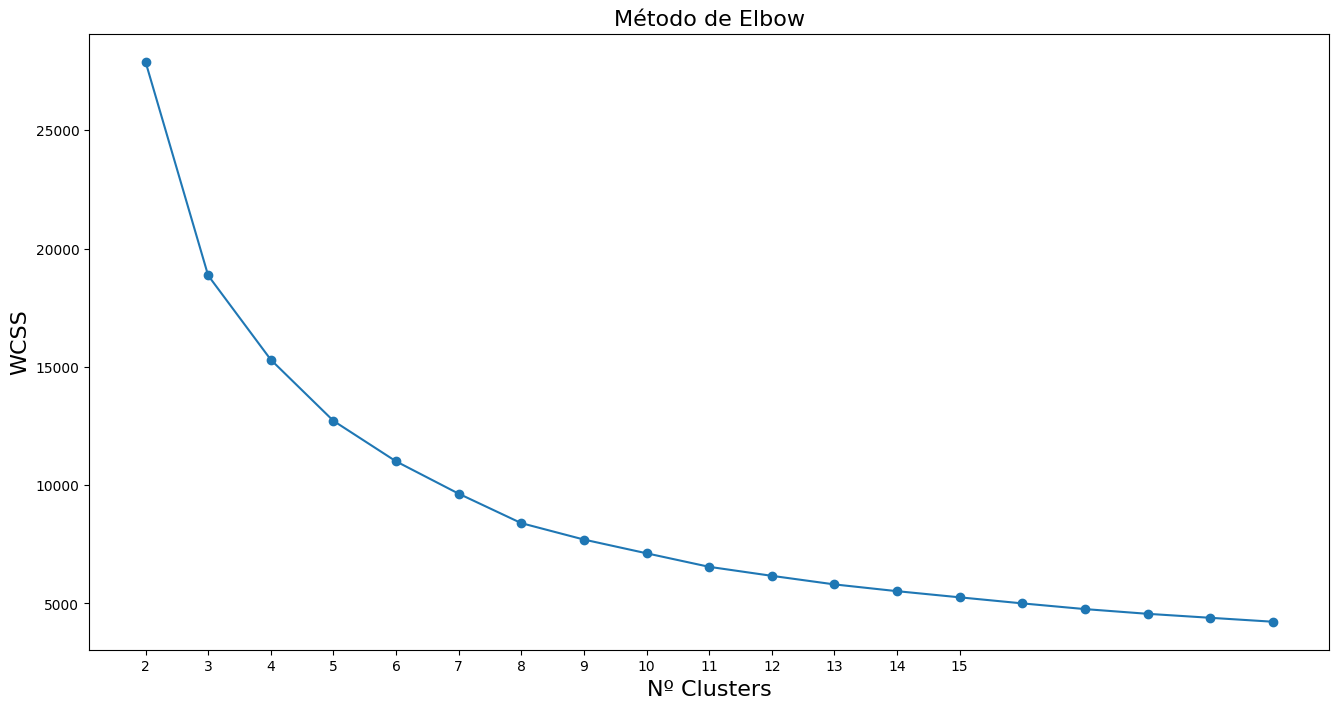

In [17]:
## Metodo elbow
################################
#Identificando a quantidade de clusters - 
elbow = []
K = range(2,21)
for k in K:
    print(k)
    kmeanElbow = KMeans(n_clusters = k , init='k-means++',n_init=50, max_iter=150, random_state =100).fit(df_cluster_fit_standard)
    elbow.append(kmeanElbow.inertia_)
    
################################# nesse caso poderia ser 7 ou 8 pois apartir do 6 o erro quadrático médio se torna menor e menos significativo, mas pensando no contexto dos dados e que estamos falando em valores altos, pode-ser que uma pequena melhora do erro quadratico medio pode ser muito siginifcativo
plot.figure(figsize=(16,8))
plot.plot(K, elbow, marker='o')
plot.xlabel('Nº Clusters', fontsize=16)
plot.xticks(range(2,16)) # ajustar range
plot.ylabel('WCSS', fontsize=16) # Soma dos Quadrados Dentro dos Clusters
plot.title('Método de Elbow', fontsize=16)
plot.show()

In [ ]:
elbow

In [28]:
def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = fabs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(builtins.max(distances)) + 2

In [21]:
# calculando a quantidade ótima de clusters
n = optimal_number_of_clusters(elbow)
print(n)

7


In [21]:
#################################
# Método K means
kmeans = KMeans(n_clusters = 5,init='k-means++',n_init=50, max_iter=150, random_state =100).fit(df_cluster_fit_standard)

#################################
print(kmeans.labels_)
print(kmeans)

[3 3 4 ... 0 4 1]
KMeans(max_iter=150, n_clusters=5, n_init=50, random_state=100)


In [22]:
#################################
## Rotualando os dados
labels = pd.DataFrame(data=kmeans.labels_)
#################################
df_cluster.loc[:, 'Cluster'] = kmeans.labels_

In [23]:
### Checando a quantidade por cluster
df_cluster.Cluster.value_counts(dropna=False)

Cluster
0    115617
3     99623
4     86500
1     85894
2     24307
Name: count, dtype: int64

In [24]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411941 entries, 0 to 411940
Data columns (total 36 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   CPF_CNPJ                             411941 non-null  float64
 1   SEXO                                 411941 non-null  object 
 2   IDADE                                411941 non-null  int32  
 3   NATUREZA_OCUPACAO                    411941 non-null  object 
 4   ESTADO_CIVIL                         402532 non-null  object 
 5   CANAL_ORIGEM                         411941 non-null  object 
 6   GRAU_ESCOLARIDADE                    384159 non-null  object 
 7   UF_RESIDENCIA                        411941 non-null  object 
 8   NACIONALIDADE                        411914 non-null  object 
 9   TEMPO_RELACIONAMENTO_KREDILIG        411941 non-null  int32  
 10  TEMPO_INATIVIDADE_KREDILIG           411941 non-null  int32  
 11  SITUACAO_CONT

In [25]:
df_cluster_csv=df_cluster[["CPF_CNPJ","Cluster"]]
#df_cluster_csv.to_csv('cluster2.csv', index=False)

<Axes: >

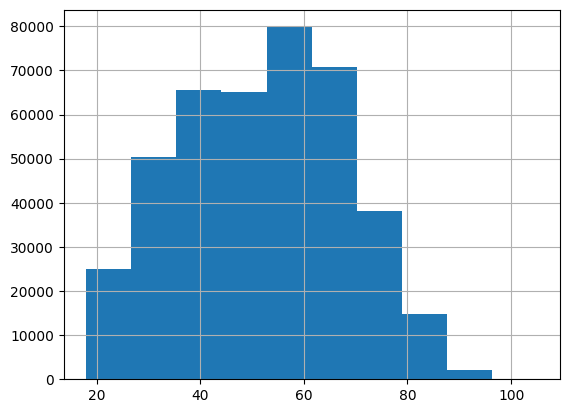

In [50]:
df_cluster["IDADE"].hist()

In [28]:
df_cluster.IDADE.describe()

count   411941.00
mean        51.93
std         16.01
min         18.00
25%         40.00
50%         52.00
75%         64.00
max        105.00
Name: IDADE, dtype: float64

In [29]:
df_cluster.IDADE.value_counts()

IDADE
59     9301
60     9193
58     9075
61     8906
62     8902
       ... 
100       9
101       3
102       2
105       1
103       1
Name: count, Length: 87, dtype: int64

In [30]:
pd.qcut(df_cluster.IDADE,q=8
       ).value_counts()

IDADE
(17.999, 32.0]    56668
(58.0, 64.0]      53525
(32.0, 40.0]      52954
(52.0, 58.0]      52377
(64.0, 71.0]      50856
(71.0, 105.0]     48914
(46.0, 52.0]      48775
(40.0, 46.0]      47872
Name: count, dtype: int64

In [26]:
# Categorizando as variáveis numéricas
df_cluster['faixa_Idade']=pd.qcut(df_cluster.IDADE,q=8)
df_cluster['faixa_Relacionamento']=pd.cut(df_cluster.TEMPO_RELACIONAMENTO_KREDILIG, 
                                          bins=[0,365,365*2,365*3,365*4,365*5,365*6,365*7,365*8, 365*9,np.inf], 
                                          labels=["Até 1 ano", "1 a 2 anos", "2 a 3 anos","3 a 4 anos","4 a 5 anos","5 a 6 anos","6 a 7 anos","7 a 8 anos","8 a 9 anos", "Acima de 9 anos"])
df_cluster['faixa_Inatividade']=pd.qcut(df_cluster.TEMPO_INATIVIDADE_KREDILIG,q=6)
df_cluster['faixa_Limite']=pd.cut(df_cluster.LIMITE_TOTAL,bins=[-0.99,0,1000,5000,10000,20000,np.inf],labels=["Sem Limite","Até R$1 mil","R$1 mil a R$5 mil","R$5 mil a R$10mil","R$10 mil a R$20mil","Acima de R$20mil"])
df_cluster['Qtd_contratos_aberto_atraso']=pd.cut(df_cluster.Qtd_contratos_aberto_atraso_total,bins=[-0.99,0,1,np.inf],labels=["0","1","+1"])
df_cluster['Qtd_contratos_aberto_regular']=pd.cut(df_cluster.Qtd_contratos_aberto_regular_total,bins=[-0.99,0,1,3,np.inf],labels=["0","1","3","+3"])
df_cluster['Qtd_contratos_fechado_atraso']=pd.cut(df_cluster.Qtd_contratos_fechado_atraso_total,bins=[-0.99,0,1,3,np.inf],labels=["0","1","3","+3"])
df_cluster['Qtd_contratos_fechado_regular']=pd.cut(df_cluster.Qtd_contratos_fechado_regular_total,bins=[-0.99,0,1,3,10,np.inf],labels=["0","1","1 a 3","4 a 10","+10"])
df_cluster['faixa_valor_da_parcela']=pd.cut(df_cluster.valor_da_parcela_aberto_total,bins=[-0.99,0,100,250,500,1000,np.inf],labels=["Sem contrato aberto","Até R$100","R$ 100 a R$250","R$251 a R$500", "R$501  a R$1 mil", "R$ Acima de R$1 mil"])
df_cluster['faixa_qtd_parcelas_pagas']=pd.cut(df_cluster.qtd_parcelas_pagas_total,bins=[-0.99,0,10,20,50,np.inf],labels=["0","Até 10","11 a 20","21 a 50", "Acima 50"])
df_cluster['faixa_qtd_parcelas_abertas']=pd.cut(df_cluster.qtd_parcelas_aberta_total,bins=[-0.99,0,10,20,50,np.inf],labels=["0","Até 10","11 a 20","21 a 50", "Acima 50"])
df_cluster['faixa_media_atraso']=pd.cut(df_cluster.media_atraso_dias,bins=[-0.99,0,1,2,3,7,15,30,60,np.inf],labels=["0","1","2","3","4 a 7","8 a 15","16 a 30","31 a 60","Acima 60"])
df_cluster['faixa_principal_total']=pd.cut(df_cluster.principal_total_total,bins=[-0.99,0,1000,2000,3000,5000,10000,np.inf],labels=["0","Até R$1 mil","R$1 mil a R$2 mil","R$2 mil a R$3mil","R$3 mil a R$4mil","R$5 mil a R$10mil","Acima de R$10mil"])
df_cluster['faixa_creditos_a_vencer']=pd.cut(df_cluster.creditos_a_vencer_total,bins=[-0.99,0,1000,2000,3000,5000,np.inf],labels=["0","Até R$1 mil","R$1 mil a R$2 mil","R$2 mil a R$3mil","R$3 mil a R$5mil","Acima de R$5mil"])
df_cluster['faixa_creditos_vencidos']=pd.cut(df_cluster.creditos_vencidos_total,bins=[-0.99,0,1000,np.inf],labels=["0","Até R$1 mil","Acima de R$1mil"])
df_cluster['faixa_media_entre_contratos']=pd.cut(df_cluster.media_dias_entre_contratos,bins=[-0.99,0,30,60,90,180,np.inf],labels=["0","Até 30","31 a 60","61 a 90","91 a 180","Acima de 180"])
df_cluster.head()


,CPF_CNPJ,SEXO,IDADE,NATUREZA_OCUPACAO,ESTADO_CIVIL,CANAL_ORIGEM,GRAU_ESCOLARIDADE,UF_RESIDENCIA,NACIONALIDADE,TEMPO_RELACIONAMENTO_KREDILIG,...,Qtd_contratos_fechado_atraso,Qtd_contratos_fechado_regular,faixa_valor_da_parcela,faixa_qtd_parcelas_pagas,faixa_qtd_parcelas_abertas,faixa_media_atraso,faixa_principal_total,faixa_creditos_a_vencer,faixa_creditos_vencidos,faixa_media_entre_contratos
0,1148044.00,F,42,PROMOTOR DE VENDAS,DIVORCIADO,Fisico,ENSINO MEDIO 2� GRAU COM,SC,BRASILEIRO,1384,...,0,1 a 3,Sem contrato aberto,21 a 50,0,3,R$3 mil a R$4mil,0,0,0
1,2030098.00,F,41,PROFESSOR ENSINO MEDIO(2 GRAU),DIVORCIADO,Fisico,ENSINO MEDIO 2� GRAU COM,SC,BRASILEIRO,441,...,0,1,Sem contrato aberto,Até 10,0,0,R$1 mil a R$2 mil,0,0,0
2,3130096.00,F,43,AGENTE COMUNITARIO DE SAUDE,CASADO,Fisico,ENSINO MEDIO 2� GRAU COM,SC,BRASILEIRO,1498,...,3,0,Sem contrato aberto,Acima 50,0,Acima 60,R$5 mil a R$10mil,0,0,0
3,3634990.00,M,46,MOTORISTA CAMINHAO,UNIAO ESTAVEL,Fisico,ENSINO MEDIO 2� GRAU COM,SC,BRASILEIRO,3036,...,0,1 a 3,Sem contrato aberto,21 a 50,0,0,R$3 mil a R$4mil,0,0,Acima de 180
4,3747921.00,F,55,PENSIONISTA,CASADO,Fisico,ENSINO MEDIO 2� GRAU INC,SC,BRASILEIRO,2233,...,1,1,Sem contrato aberto,21 a 50,0,8 a 15,R$1 mil a R$2 mil,0,0,0


### Análise dos grupos

In [ ]:
#################################
# Estatísticas das variáveis numéricas
#################################
descritiva = df_cluster.groupby('Cluster').agg({
    "IDADE":['min','mean', 'median','max', 'std'],
    #"RENDA_DIGITADA":['min','mean', 'median','max', 'std'],
    "TEMPO_RELACIONAMENTO_KREDILIG":['min','mean', 'median','max', 'std'],
    "TEMPO_INATIVIDADE_KREDILIG":['min','mean', 'median','max', 'std'],
    #"SCORE":['min','mean', 'median','max', 'std'],
    "LIMITE_TOTAL":['min','mean', 'median','max', 'std'],
    "LIMITE_A_VISTA":['min','mean', 'median','max', 'std'],
    "LIMITE_SAQUE":['min','mean', 'median','max', 'std'],
    "LIMITE_MENSAL":['min','mean', 'median','max', 'std'],
    #"qtd_contratos_reneg_total":['min','mean', 'median','max', 'std'],
    "Qtd_contratos_aberto_atraso_total":['min','mean', 'median','max', 'std'],
    "Qtd_contratos_aberto_regular_total":['min','mean', 'median','max', 'std'],
    "Qtd_contratos_fechado_atraso_total":['min','mean', 'median','max', 'std'],
    "Qtd_contratos_fechado_regular_total":['min','mean', 'median','max', 'std'],
    "valor_da_parcela_aberto_total":['min','mean', 'median','max', 'std'],
    #"Renda_comprometida":['min','mean', 'median','max', 'std'],
    "qtd_parcelas_pagas_total":['min','mean', 'median','max', 'std'],
    "qtd_parcelas_aberta_total":['min','mean', 'median','max', 'std'],
    "media_atraso_dias":['min','mean', 'median','max', 'std'],
    "principal_total_total":['min','mean', 'median','max', 'std'],
    "creditos_a_vencer_total":['min','mean', 'median','max', 'std'],
    "creditos_vencidos_total":['min','mean', 'median','max', 'std'],
    "media_dias_entre_contratos" :['min','mean', 'median','max', 'std', 'count'],
    #"Qtd_produtos" :['min','mean', 'median','max', 'std','count']
})
#descritiva.to_excel("descritiva_cluster2.xlsx")
#################################

In [50]:
df_cluster.columns.to_list()

['CPF_CNPJ',
 'SEXO',
 'IDADE',
 'NATUREZA_OCUPACAO',
 'ESTADO_CIVIL',
 'CANAL_ORIGEM',
 'GRAU_ESCOLARIDADE',
 'UF_RESIDENCIA',
 'NACIONALIDADE',
 'TEMPO_RELACIONAMENTO_KREDILIG',
 'TEMPO_INATIVIDADE_KREDILIG',
 'SITUACAO_CONTA',
 'SITUACAO_FATURA',
 'LIMITE_TOTAL',
 'LIMITE_A_VISTA',
 'LIMITE_SAQUE',
 'LIMITE_MENSAL',
 'CDC',
 'CP',
 'CREDIARIO',
 'CARTAO',
 'Qtd_contratos_aberto_atraso_total',
 'Qtd_contratos_aberto_regular_total',
 'Qtd_contratos_fechado_atraso_total',
 'Qtd_contratos_fechado_regular_total',
 'valor_da_parcela_aberto_total',
 'qtd_parcelas_pagas_total',
 'qtd_parcelas_aberta_total',
 'media_atraso_dias',
 'principal_total_total',
 'creditos_a_vencer_total',
 'creditos_vencidos_total',
 'media_dias_entre_contratos',
 'Inad_e_reneg',
 'Cluster',
 'faixa_Idade',
 'faixa_Relacionamento',
 'faixa_Inatividade',
 'faixa_Limite',
 'Qtd_contratos_aberto_atraso',
 'Qtd_contratos_aberto_regular',
 'Qtd_contratos_fechado_atraso',
 'Qtd_contratos_fechado_regular',
 'faixa_valor_

In [ ]:
tabelas_de_contingencia = {}

variavel_alvo = 'Cluster'

# Selecionando apenas colunas categóricas
colunas_categoricas = [
 'NATUREZA_OCUPACAO',
 'SEXO',
 'ESTADO_CIVIL',
 'CANAL_ORIGEM',
 'GRAU_ESCOLARIDADE',
 'UF_RESIDENCIA',
 'NACIONALIDADE',
 'SITUACAO_CONTA',
 'SITUACAO_FATURA',
 'CANAL_ORIGEM',
 'CDC',
 'CP',
 'CREDIARIO',
 'CARTAO',
 'Inad_e_reneg',
 'Qtd_contratos_aberto_atraso',
 'Qtd_contratos_aberto_regular',
 'Qtd_contratos_fechado_atraso',
 'Qtd_contratos_fechado_regular',
 'faixa_Idade',
 'faixa_Relacionamento',
 'faixa_Inatividade',
 'faixa_Limite',
 'faixa_valor_da_parcela',
 'faixa_qtd_parcelas_pagas',
 'faixa_qtd_parcelas_abertas',
 'faixa_media_atraso',
 'faixa_principal_total',
 'faixa_creditos_a_vencer',
 'faixa_creditos_vencidos',
 'faixa_media_entre_contratos']

# Criando tabelas de contingência para cada variável categórica
for col in colunas_categoricas:
    print(f"\nTabela de Contingência: {col} x {variavel_alvo}")
    tabela =pd.crosstab(df_cluster[col], df_cluster[variavel_alvo])
    tabelas_de_contingencia[col]=tabela
    print(tabela)

'''#Criando um nome de arquivo com data
nome_arquivo = f"tabelas_cluster2.xlsx"

# Salvando no Excel
with pd.ExcelWriter(nome_arquivo, engine="xlsxwriter") as writer:
    for col, tabela in tabelas_de_contingencia.items():
        tabela.to_excel(writer, sheet_name=col)'''


Tabela de Contingência: NATUREZA_OCUPACAO x Cluster
Cluster                  0    1    2    3     4
NATUREZA_OCUPACAO                              
ABATEDOR                23   12    7   10    27
ACOUGUEIRO             184  226  221   92   294
ACROBATA                 2    1    0    0     0
ACUPUNTURISTA            4    1    2    0     2
ADESTRADOR DE ANIMAIS    8    6    8    3     8
...                    ...  ...  ...  ...   ...
VISUAL MERCHANDISER      4    5    7    1     5
VIVEIRISTA FLORESTAL     7    2    2    2     7
WEB DESIGNER             3    0    0    2     4
ZELADOR                781  526  635  162  1001
ZOOTECNISTA              0    0    1    0     1

[831 rows x 5 columns]

Tabela de Contingência: SEXO x Cluster
Cluster           0      1      2      3      4
SEXO                                           
DESCONHECIDO     13      0      7     25    103
F             55490  41444  45360  10662  66226
M             44127  44448  41132  13623  49281

Tabela de Contingê

### Spark

In [14]:
df_cluster_csv=spark.read.csv("C:/Users/fernando.monteiro/deep-torch-example/KAB/Behavior_KAB/cluster.csv",header=True,inferSchema=True, sep=",")

df_clientes_historico = (
        df_clientes_historico
        .join(df_cluster_csv, on="cpf_cnpj", how="left")
    )
df_clientes_historico.printSchema()

root
 |-- CPF_CNPJ: double (nullable = false)
 |-- ANO_MES_MOVIMENTO: timestamp (nullable = true)
 |-- DATA_MOVIMENTO: date (nullable = true)
 |-- SEXO: string (nullable = true)
 |-- IDADE: integer (nullable = true)
 |-- ESTADO_CIVIL: string (nullable = true)
 |-- GRAU_ESCOLARIDADE: string (nullable = true)
 |-- NATUREZA_OCUPACAO: string (nullable = true)
 |-- RENDA_DIGITADA: double (nullable = false)
 |-- RENDA_VALIDA: double (nullable = false)
 |-- NACIONALIDADE: string (nullable = true)
 |-- UF_NASCIMENTO: string (nullable = true)
 |-- CIDADE_NASCIMENTO: string (nullable = true)
 |-- UF_RESIDENCIA: string (nullable = true)
 |-- CIDADE_RESIDENCIA: string (nullable = true)
 |-- FILIAL: string (nullable = true)
 |-- TEMPO_RELACIONAMENTO_KREDILIG: integer (nullable = true)
 |-- TEMPO_INATIVIDADE_KREDILIG: integer (nullable = true)
 |-- BLACKLIST: string (nullable = true)
 |-- DATA_ABERTURA_CONTA: date (nullable = true)
 |-- SITUACAO_CONTA: string (nullable = true)
 |-- MOTIVO_SITUACAO_C

In [15]:
tabela_cruzada = df_clientes_historico.crosstab("MOTIVO_SITUACAO_CONTA", "Cluster")
tabela_cruzada.show()


+-----------------------------+-----+-----+-----+-----+-----+----+-----+
|MOTIVO_SITUACAO_CONTA_Cluster|    0|    1|    2|    3|    4|   5|    6|
+-----------------------------+-----+-----+-----+-----+-----+----+-----+
|                  INATIVIDADE|15474|    0|36843|33438|   48|5182|    1|
|                   REATIVACAO|    0|    1|    0|    1|    0|   0|    0|
|                     ATRASO B|33931|    6|14314|24564|  246|9221|    2|
|                    CANCELADO| 1452|    0| 1209| 1193|   14| 714|    0|
|                        PAGTO| 1319|15321|  100|  427| 6123| 346|17757|
|           LIBERA/BLOQ CARTAO|  976|   13|  124|  282|  345|5732|   51|
|                  DESBLOQUEIO|   10|   36|    0|    1|   13|   2|   57|
|                       ATRASO|  243| 2952|   22|   91| 1662|  11| 3076|
|              CANCELADOATRASO|    4|    0|  440|  211|    0|   3|    0|
|                         null| 3446|72542|  669| 1215|49200|2282|46983|
+-----------------------------+-----+-----+-----+--

## Dados sem histórico

In [12]:
df_clientes_sem_historico=df_final.filter(col("Qtd_produtos")==0) ## 122 mil não possuem histórico
df_clientes_sem_historico.count()

122432

In [11]:
# Arquivo para Pandas

'''
"SEXO",                        
"IDADE",
"NATUREZA_OCUPACAO",
"ESTADO_CIVIL",
"CANAL_ORIGEM",
"GRAU_ESCOLARIDADE",
"UF_RESIDENCIA",
"NACIONALIDADE",
#"RENDA_DIGITADA",'''

df_sem_historico_select=df_clientes_sem_historico.select("CPF_CNPJ",
"TEMPO_RELACIONAMENTO_KREDILIG",
"TEMPO_INATIVIDADE_KREDILIG",
"SITUACAO_CONTA",
"SITUACAO_FATURA",
"LIMITE_TOTAL",
"LIMITE_A_VISTA",
"LIMITE_SAQUE",
"LIMITE_MENSAL",
"CDC",
"CP",
"CREDIARIO",
"CARTAO",
"Qtd_contratos_aberto_atraso_total",
"Qtd_contratos_aberto_regular_total",
"Qtd_contratos_fechado_atraso_total",
"Qtd_contratos_fechado_regular_total",
"valor_da_parcela_aberto_total",
"qtd_parcelas_pagas_total",
"qtd_parcelas_aberta_total",
"media_atraso_dias",
"principal_total_total",
"creditos_a_vencer_total",
"creditos_vencidos_total",
"media_dias_entre_contratos",
"Inad_e_reneg").toPandas()

In [ ]:
#pd.set_option('display.max_columns', None)
df_sem_historico_select.head()

,CPF_CNPJ,TEMPO_RELACIONAMENTO_KREDILIG,TEMPO_INATIVIDADE_KREDILIG,SITUACAO_CONTA,SITUACAO_FATURA,LIMITE_TOTAL,LIMITE_A_VISTA,LIMITE_SAQUE,LIMITE_MENSAL,CDC,CP,CREDIARIO,CARTAO,Qtd_contratos_aberto_atraso_total,Qtd_contratos_aberto_regular_total,Qtd_contratos_fechado_atraso_total,Qtd_contratos_fechado_regular_total,valor_da_parcela_aberto_total,qtd_parcelas_pagas_total,qtd_parcelas_aberta_total,media_atraso_dias,principal_total_total,creditos_a_vencer_total,creditos_vencidos_total,media_dias_entre_contratos,Inad_e_reneg
0,4028937.00,1108,208,Bloqueada,A,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0.00,NAO
1,4231902.00,1675,0,Cancelada,None,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0.00,NAO
2,5473950.00,296,16,Ativa,L,6354.00,1144.00,1910.00,353.00,0,0,0,0,0,0,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0.00,NAO
3,6227961.00,2718,0,Cancelada,None,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0.00,NAO
4,7087985.00,12,0,Ativa,None,2000.00,360.00,0.00,200.00,0,0,0,0,0,0,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0.00,NAO


In [18]:
df_sem_historico_select.describe()

,CPF_CNPJ,TEMPO_RELACIONAMENTO_KREDILIG,TEMPO_INATIVIDADE_KREDILIG,LIMITE_TOTAL,LIMITE_A_VISTA,LIMITE_SAQUE,LIMITE_MENSAL,CDC,CP,CREDIARIO,CARTAO,Qtd_contratos_aberto_atraso_total,Qtd_contratos_aberto_regular_total,Qtd_contratos_fechado_atraso_total,Qtd_contratos_fechado_regular_total,valor_da_parcela_aberto_total,qtd_parcelas_pagas_total,qtd_parcelas_aberta_total,media_atraso_dias,principal_total_total,creditos_a_vencer_total,creditos_vencidos_total,media_dias_entre_contratos
count,122432.00,122432.00,122432.00,122432.00,122432.00,122432.00,122432.00,122432.00,122432.00,122432.00,122432.00,122432.00,122432.00,122432.00,122432.00,122432.00,122432.00,122432.00,122432.00,122432.00,122432.00,122432.00,122432.00
mean,28530006050.41,1237.12,218.31,1804.95,322.74,520.35,117.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
std,30742269722.07,935.66,393.93,3059.96,547.91,1098.75,185.37,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
min,344010.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,5300544470.50,500.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,10309050943.00,981.00,7.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,53792314466.25,1926.00,316.00,2569.25,450.00,210.00,188.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,99996766187.00,3638.00,3444.00,38400.00,8000.00,15360.00,2880.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [19]:
df_sem_historico_select.sample(20)

,CPF_CNPJ,TEMPO_RELACIONAMENTO_KREDILIG,TEMPO_INATIVIDADE_KREDILIG,SITUACAO_CONTA,SITUACAO_FATURA,LIMITE_TOTAL,LIMITE_A_VISTA,LIMITE_SAQUE,LIMITE_MENSAL,CDC,CP,CREDIARIO,CARTAO,Qtd_contratos_aberto_atraso_total,Qtd_contratos_aberto_regular_total,Qtd_contratos_fechado_atraso_total,Qtd_contratos_fechado_regular_total,valor_da_parcela_aberto_total,qtd_parcelas_pagas_total,qtd_parcelas_aberta_total,media_atraso_dias,principal_total_total,creditos_a_vencer_total,creditos_vencidos_total,media_dias_entre_contratos,Inad_e_reneg
120684,81352182149.00,3148,0,Cancelada,None,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0.00,NAO
50653,8411457923.00,1097,33,Bloqueada,A,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0.00,NAO
86874,62950177972.00,3063,0,Cancelada,None,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0.00,NAO
65554,8396781931.00,127,29,Ativa,A,1000.00,100.00,100.00,100.00,0,0,0,0,0,0,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0.00,NAO
13857,83357157934.00,583,0,Ativa,None,7152.00,1287.00,2860.00,298.00,0,0,0,0,0,0,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0.00,NAO
73577,86159321900.00,1106,106,Ativa,L,7480.00,1346.00,2618.00,499.00,0,0,0,0,0,0,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0.00,NAO
15544,729706931.00,975,376,Bloqueada,L,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0.00,NAO
69976,42579724915.00,761,408,Ativa,L,5060.00,911.00,1771.00,332.00,0,0,0,0,0,0,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0.00,NAO
30813,1654078085.00,195,0,Ativa,None,1500.00,270.00,0.00,125.00,0,0,0,0,0,0,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0.00,NAO
7770,10642458979.00,1121,0,Cancelada,None,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0.00,NAO


## Teste

In [27]:
# Porcentagem de valores faltantes
print(((df_cluster.isnull().sum() / df_cluster.shape[0]) * 100).sort_values(ascending=False))

MOTIVO_SITUACAO_CONTA                 42.81
GRAU_ESCOLARIDADE                      6.74
ESTADO_CIVIL                           2.28
faixa_Relacionamento                   0.03
NACIONALIDADE                          0.01
NATUREZA_OCUPACAO                      0.00
SEXO                                   0.00
IDADE                                  0.00
UF_RESIDENCIA                          0.00
TEMPO_RELACIONAMENTO_KREDILIG          0.00
TEMPO_INATIVIDADE_KREDILIG             0.00
CPF_CNPJ                               0.00
SITUACAO_CONTA                         0.00
SITUACAO_FATURA                        0.00
LIMITE_TOTAL                           0.00
LIMITE_A_VISTA                         0.00
LIMITE_SAQUE                           0.00
LIMITE_MENSAL                          0.00
CDC                                    0.00
CANAL_ORIGEM                           0.00
CP                                     0.00
CREDIARIO                              0.00
Qtd_contratos_aberto_atraso_tota

In [31]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411941 entries, 0 to 411940
Data columns (total 50 columns):
 #   Column                               Non-Null Count   Dtype   
---  ------                               --------------   -----   
 0   SEXO                                 411941 non-null  object  
 1   IDADE                                411941 non-null  int32   
 2   NATUREZA_OCUPACAO                    411941 non-null  object  
 3   ESTADO_CIVIL                         402532 non-null  object  
 4   CANAL_ORIGEM                         411941 non-null  object  
 5   GRAU_ESCOLARIDADE                    384159 non-null  object  
 6   UF_RESIDENCIA                        411941 non-null  object  
 7   NACIONALIDADE                        411914 non-null  object  
 8   TEMPO_RELACIONAMENTO_KREDILIG        411941 non-null  int32   
 9   TEMPO_INATIVIDADE_KREDILIG           411941 non-null  int32   
 10  SITUACAO_CONTA                       411941 non-null  object  
 11  

In [ ]:
# Separação em teste e treino

#Variável de interesse
outcome = df_cluster >> select(X.Inad_e_reneg)

# Remover a variável resposta do conjunto de dados
df_cluster.drop(['Inad_e_reneg', 'CPF_CNPJ'],axis=1, inplace=True)

In [36]:
# one hot encoding 

# Cria o codificador
codificador = LabelEncoder()

# Converte colunas de texto em números
for coluna in df_cluster.columns:
    if df_cluster[coluna].dtype == "object":
        df_cluster[coluna] = df_cluster[coluna].astype(str)
        df_cluster[coluna] = codificador.fit_transform(df_cluster[coluna])

# Verifica as alterações
print(df_cluster.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411941 entries, 0 to 411940
Data columns (total 50 columns):
 #   Column                               Non-Null Count   Dtype   
---  ------                               --------------   -----   
 0   SEXO                                 411941 non-null  int64   
 1   IDADE                                411941 non-null  int32   
 2   NATUREZA_OCUPACAO                    411941 non-null  int64   
 3   ESTADO_CIVIL                         411941 non-null  int64   
 4   CANAL_ORIGEM                         411941 non-null  int64   
 5   GRAU_ESCOLARIDADE                    411941 non-null  int64   
 6   UF_RESIDENCIA                        411941 non-null  int64   
 7   NACIONALIDADE                        411941 non-null  int64   
 8   TEMPO_RELACIONAMENTO_KREDILIG        411941 non-null  int32   
 9   TEMPO_INATIVIDADE_KREDILIG           411941 non-null  int32   
 10  SITUACAO_CONTA                       411941 non-null  int64   
 11  

In [41]:
# amostragem

## Definindo treino e teste
X_train, X_test, y_train, y_test=train_test_split(df_cluster,outcome, test_size=0.3)

# variável Salario
X_train = X_train[[
 'SEXO',
 'IDADE',
 'NATUREZA_OCUPACAO',
 'ESTADO_CIVIL',
 'CANAL_ORIGEM',
 'GRAU_ESCOLARIDADE',
 'UF_RESIDENCIA',
 'NACIONALIDADE',
 'TEMPO_RELACIONAMENTO_KREDILIG',
 'TEMPO_INATIVIDADE_KREDILIG',
 'LIMITE_TOTAL',
 'LIMITE_A_VISTA',
 'LIMITE_SAQUE',
 'LIMITE_MENSAL',
 'CDC',
 'CP',
 'CREDIARIO',
 'CARTAO',
 'Qtd_contratos_aberto_regular_total',
 'Qtd_contratos_fechado_atraso_total',
 'Qtd_contratos_fechado_regular_total',
 'valor_da_parcela_aberto_total',
 'qtd_parcelas_pagas_total',
 'qtd_parcelas_aberta_total',
 'media_atraso_dias',
 'principal_total_total',
 'creditos_a_vencer_total',
 'creditos_vencidos_total',
 'media_dias_entre_contratos',
 'Cluster']]

In [42]:
X_train.columns.to_list()

['SEXO',
 'IDADE',
 'NATUREZA_OCUPACAO',
 'ESTADO_CIVIL',
 'CANAL_ORIGEM',
 'GRAU_ESCOLARIDADE',
 'UF_RESIDENCIA',
 'NACIONALIDADE',
 'TEMPO_RELACIONAMENTO_KREDILIG',
 'TEMPO_INATIVIDADE_KREDILIG',
 'LIMITE_TOTAL',
 'LIMITE_A_VISTA',
 'LIMITE_SAQUE',
 'LIMITE_MENSAL',
 'CDC',
 'CP',
 'CREDIARIO',
 'CARTAO',
 'Qtd_contratos_aberto_regular_total',
 'Qtd_contratos_fechado_atraso_total',
 'Qtd_contratos_fechado_regular_total',
 'valor_da_parcela_aberto_total',
 'qtd_parcelas_pagas_total',
 'qtd_parcelas_aberta_total',
 'media_atraso_dias',
 'principal_total_total',
 'creditos_a_vencer_total',
 'creditos_vencidos_total',
 'media_dias_entre_contratos',
 'Cluster']

In [43]:
X_train.shape #qtd treino

(288358, 30)

In [44]:
X_test.shape #qtd treino

(123583, 50)

In [ ]:
# importancia, VIF, assimetria, seleção de variáveis, correlação

In [55]:
# VIF, correlação, assimetria
from statsmodels.stats.outliers_influence import variance_inflation_factor


vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
  
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]
print(vif_data.sort_values(by=['VIF'], ascending=False))

                                Feature   VIF
6         TEMPO_RELACIONAMENTO_KREDILIG 11.35
20                principal_total_total 10.92
17             qtd_parcelas_pagas_total 10.23
1                                 IDADE  9.89
0                                  SEXO  7.67
16        valor_da_parcela_aberto_total  7.58
15  Qtd_contratos_fechado_regular_total  6.64
21              creditos_a_vencer_total  6.34
18            qtd_parcelas_aberta_total  6.13
13   Qtd_contratos_aberto_regular_total  6.12
12                               CARTAO  5.70
4                     GRAU_ESCOLARIDADE  5.46
8                          LIMITE_TOTAL  3.28
2                     NATUREZA_OCUPACAO  3.22
11                            CREDIARIO  3.16
24                              Cluster  3.03
22              creditos_vencidos_total  2.73
7            TEMPO_INATIVIDADE_KREDILIG  2.72
14   Qtd_contratos_fechado_atraso_total  2.12
23           media_dias_entre_contratos  2.04
10                                

In [ ]:
X_train.drop(['CANAL_ORIGEM','UF_RESIDENCIA', 'LIMITE_A_VISTA',
 'LIMITE_SAQUE',
 'LIMITE_MENSAL'],axis=1, inplace=True) # talvez somar as var de limites

<function matplotlib.pyplot.show(close=None, block=None)>

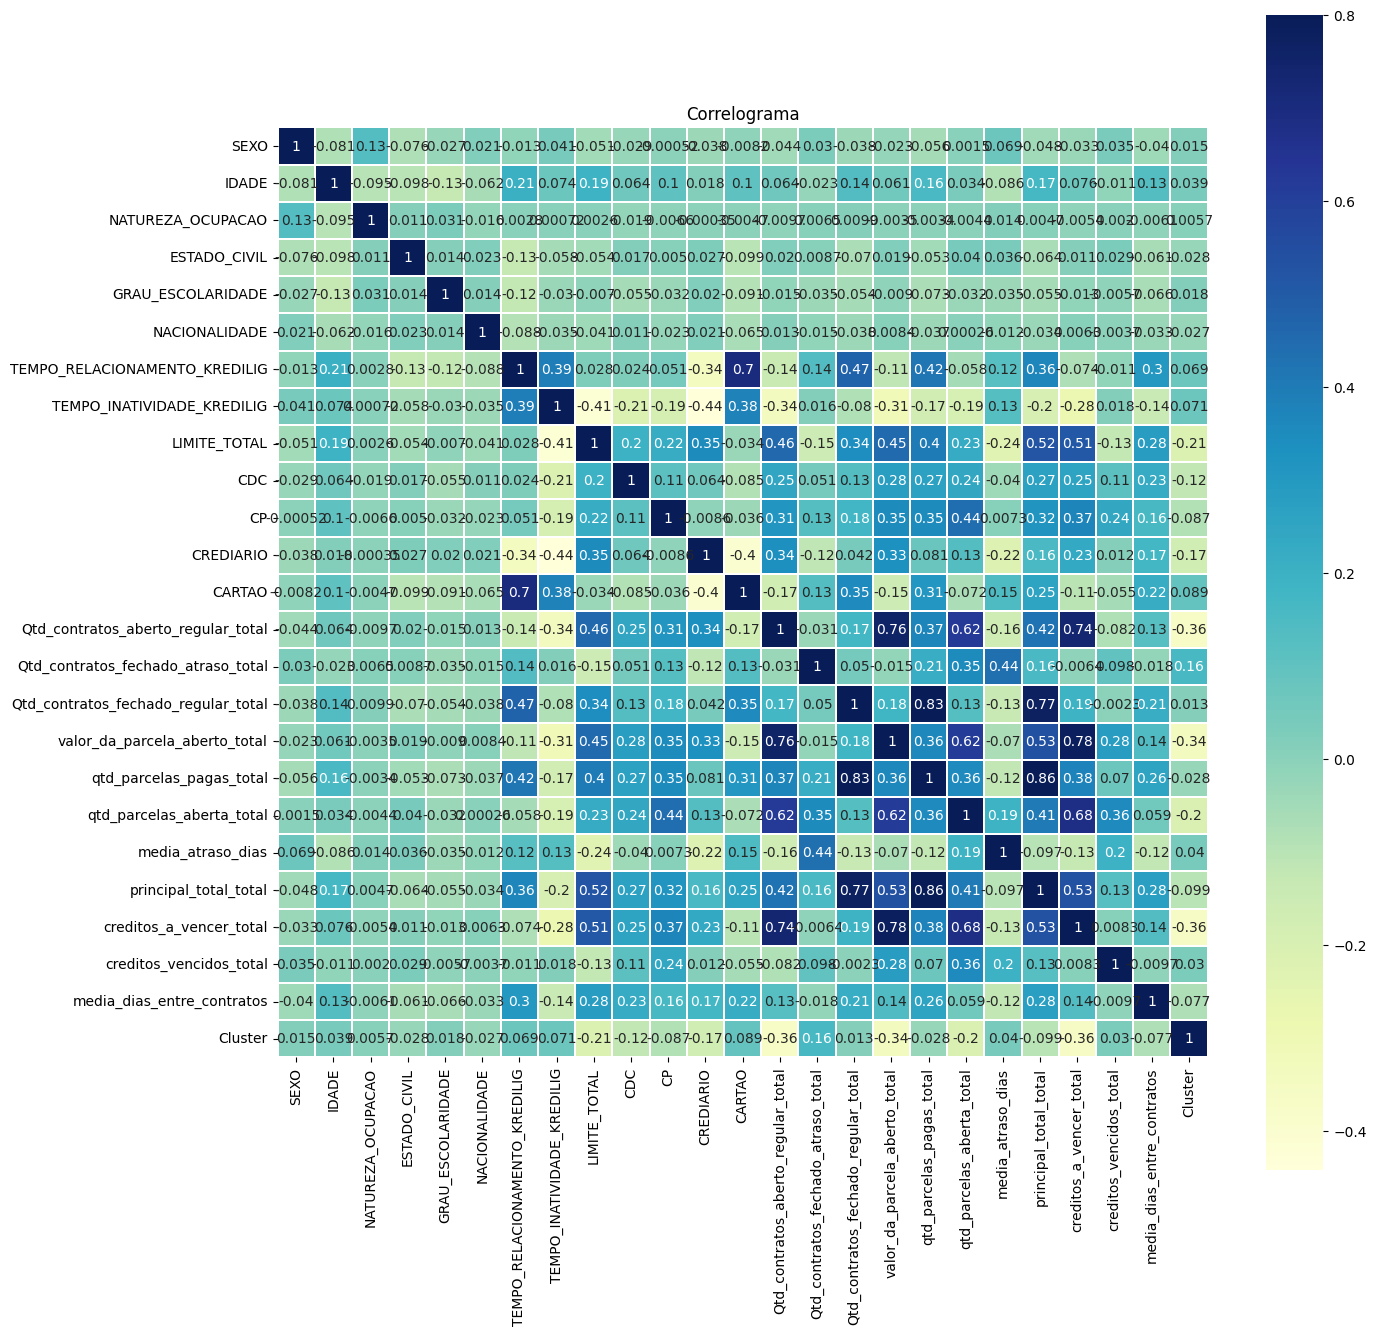

In [56]:
# Correlação
# Pearson
corr=X_train.corr(method='pearson')
plot.figure(figsize=(15,15))
sns.heatmap(corr,vmax=0.8,linewidths=0.01,
           square=True, annot=True,cmap='YlGnBu', linecolor='white')
plot.title('Correlograma')
plot.show

In [57]:
from scipy.stats import skew ## Assimetria                         ESTUDAR
skewed_feats=X_train.apply(lambda x: skew(x.dropna()))
print(skewed_feats.sort_values(ascending=False))

NACIONALIDADE                         11.89
creditos_vencidos_total                8.66
Qtd_contratos_fechado_atraso_total     5.50
Qtd_contratos_fechado_regular_total    5.16
creditos_a_vencer_total                4.58
principal_total_total                  4.50
valor_da_parcela_aberto_total          4.23
qtd_parcelas_aberta_total              4.18
media_atraso_dias                      4.02
Qtd_contratos_aberto_regular_total     3.77
qtd_parcelas_pagas_total               3.67
media_dias_entre_contratos             2.67
LIMITE_TOTAL                           1.97
TEMPO_INATIVIDADE_KREDILIG             1.92
CP                                     1.50
GRAU_ESCOLARIDADE                      1.37
CDC                                    0.97
ESTADO_CIVIL                           0.40
NATUREZA_OCUPACAO                      0.38
SEXO                                   0.12
Cluster                                0.07
CREDIARIO                             -0.00
IDADE                           

In [60]:
# Variancia nula                                                    ESTUDAR
from sklearn.feature_selection import VarianceThreshold
constant_features=[feat for feat in X_train.columns if X_train[feat].std()==0]
constant_features

[]

In [ ]:
# imputação

In [67]:
#normalização
# Padronização dos dados de treino e teste
sc = StandardScaler()
## Valores da padronização são obtidos em relação ao dados de treino
sc.fit(X_train)

StandardScaler()

In [68]:
sc.mean_

array([-2.93694293, -3.24426079, -1.49884327, -0.9512437 , -2.39438096,
       -0.0849841 , -1.7539969 , -0.69846153, -0.74456793, -0.62687579,
       -0.50059814, -1.00170767, -1.22309352, -0.50743575, -0.32791839,
       -0.63248592, -0.56891623, -0.71163435, -0.55455714, -0.33538054,
       -0.77792716, -0.42660098, -0.24185316, -0.66578224, -1.22096845])

In [69]:
sc.var_

array([4.00634593e+00, 3.90226272e-03, 1.79338744e-05, 3.15456132e-01,
       5.70544732e-01, 1.35529915e+02, 1.03864156e-06, 2.55881632e-06,
       2.76620703e-08, 4.93767571e+00, 6.24104535e+00, 4.00001164e+00,
       4.16442583e+00, 8.51101648e-01, 1.13800941e+00, 3.30239374e-02,
       1.78818811e-05, 3.20421463e-04, 3.52682755e-03, 2.25988276e-05,
       1.74643056e-08, 1.32641722e-07, 8.73361319e-07, 5.47044356e-05,
       4.16758082e-01])

In [70]:
# padronização dos dados de treinamento
X_train = pd.DataFrame(sc.transform(X_train), columns=X_train.columns)

In [71]:
X_train.head()
X_train.mean()
X_train.var()

SEXO                                  1.00
IDADE                                 1.00
NATUREZA_OCUPACAO                     1.00
ESTADO_CIVIL                          1.00
GRAU_ESCOLARIDADE                     1.00
NACIONALIDADE                         1.00
TEMPO_RELACIONAMENTO_KREDILIG         1.00
TEMPO_INATIVIDADE_KREDILIG            1.00
LIMITE_TOTAL                          1.00
CDC                                   1.00
CP                                    1.00
CREDIARIO                             1.00
CARTAO                                1.00
Qtd_contratos_aberto_regular_total    1.00
Qtd_contratos_fechado_atraso_total    1.00
Qtd_contratos_fechado_regular_total   1.00
valor_da_parcela_aberto_total         1.00
qtd_parcelas_pagas_total              1.00
qtd_parcelas_aberta_total             1.00
media_atraso_dias                     1.00
principal_total_total                 1.00
creditos_a_vencer_total               1.00
creditos_vencidos_total               1.00
media_dias_

In [73]:
X_train.head()

,SEXO,IDADE,NATUREZA_OCUPACAO,ESTADO_CIVIL,GRAU_ESCOLARIDADE,NACIONALIDADE,TEMPO_RELACIONAMENTO_KREDILIG,TEMPO_INATIVIDADE_KREDILIG,LIMITE_TOTAL,CDC,...,Qtd_contratos_fechado_regular_total,valor_da_parcela_aberto_total,qtd_parcelas_pagas_total,qtd_parcelas_aberta_total,media_atraso_dias,principal_total_total,creditos_a_vencer_total,creditos_vencidos_total,media_dias_entre_contratos,Cluster
0,-0.94,2.32,0.76,-0.95,-1.64,-0.08,-0.34,-0.22,2.34,-0.63,...,0.09,-0.57,0.06,-0.55,-0.28,0.22,-0.43,-0.24,-0.54,0.72
1,-0.94,0.00,-0.13,0.73,0.63,-0.08,0.61,-0.05,-0.74,1.60,...,0.28,-0.57,0.72,0.40,0.23,0.61,-0.43,-0.24,1.50,1.36
2,1.07,1.38,-0.67,-0.95,-0.13,-0.08,1.28,-0.70,0.06,1.60,...,0.82,-0.57,1.15,-0.55,-0.33,0.66,-0.43,-0.24,1.92,-1.22
3,1.07,-1.25,-0.97,0.73,-0.13,-0.08,0.36,0.11,-0.74,-0.63,...,0.64,-0.57,0.83,-0.55,-0.34,0.83,-0.43,-0.24,-0.13,1.36
4,-0.94,0.44,-0.72,-0.95,-0.13,-0.08,-0.07,1.74,-0.74,-0.63,...,-0.45,-0.57,-0.66,-0.55,-0.34,-0.69,-0.43,-0.24,-0.67,-0.58


In [ ]:
#superamostragem

In [76]:
#modelo

# modelo de XGBoost
#!pip install xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Criando um modelo XGBoost
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

## parâmtros
parameters = {'objective':['reg:linear'],
              'learning_rate':[0.045,0.05,0.06],
              'max_depth':[3,4,5],
              'min_child_weight':[2,3,4],
              'silent':[1],
              'subsample':[0.5,0.55,0.6],
              'colsample_bytree':[0.7,0.8,0.85],
              'n_estimators': [50, 100, 200]}

## ajustando o modelo
xgb_grid = GridSearchCV(
    xgb_model,
    parameters,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=5,
    verbose=True
)

In [77]:
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


ValueError: 
All the 3645 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3645 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\.venv\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\.venv\Lib\site-packages\xgboost\sklearn.py", line 1143, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\.venv\Lib\site-packages\xgboost\sklearn.py", line 603, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "c:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\.venv\Lib\site-packages\xgboost\sklearn.py", line 1065, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "c:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\.venv\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\.venv\Lib\site-packages\xgboost\core.py", line 1573, in __init__
    self._init(
  File "c:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\.venv\Lib\site-packages\xgboost\core.py", line 1632, in _init
    it.reraise()
  File "c:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\.venv\Lib\site-packages\xgboost\core.py", line 569, in reraise
    raise exc  # pylint: disable=raising-bad-type
    ^^^^^^^^^
  File "c:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\.venv\Lib\site-packages\xgboost\core.py", line 550, in _handle_exception
    return fn()
           ^^^^
  File "c:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\.venv\Lib\site-packages\xgboost\core.py", line 637, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
                                          ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\.venv\Lib\site-packages\xgboost\data.py", line 1402, in next
    input_data(**self.kwargs)
  File "c:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\.venv\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\.venv\Lib\site-packages\xgboost\core.py", line 626, in input_data
    self.proxy.set_info(
  File "c:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\.venv\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\.venv\Lib\site-packages\xgboost\core.py", line 954, in set_info
    self.set_label(label)
  File "c:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\.venv\Lib\site-packages\xgboost\core.py", line 1092, in set_label
    dispatch_meta_backend(self, label, "label", "float")
  File "c:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\.venv\Lib\site-packages\xgboost\data.py", line 1345, in dispatch_meta_backend
    _meta_from_pandas_df(data, name, dtype=dtype, handle=handle)
  File "c:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\.venv\Lib\site-packages\xgboost\data.py", line 621, in _meta_from_pandas_df
    data, _, _ = _transform_pandas_df(data, False, meta=name)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\.venv\Lib\site-packages\xgboost\data.py", line 603, in _transform_pandas_df
    pandas_check_dtypes(data, enable_categorical)
  File "c:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\.venv\Lib\site-packages\xgboost\data.py", line 569, in pandas_check_dtypes
    _invalid_dataframe_dtype(data)
  File "c:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\.venv\Lib\site-packages\xgboost\data.py", line 356, in _invalid_dataframe_dtype
    raise ValueError(msg)
ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Inad_e_reneg: object


In [ ]:
xgb = xgb_grid.best_estimator_

In [ ]:
# diag comparação

# pontuação

# interpretação SHAP

# escore

# limite